In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "fsv3"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 297
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 369
Categorical Columns: 8


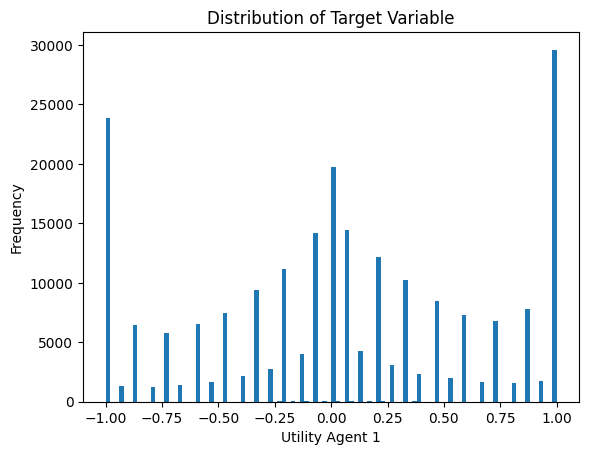

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.502739


[200]	valid_0's rmse: 0.48214


[300]	valid_0's rmse: 0.47065


[400]	valid_0's rmse: 0.463068


[500]	valid_0's rmse: 0.458612


[600]	valid_0's rmse: 0.45505


[700]	valid_0's rmse: 0.452794


[800]	valid_0's rmse: 0.451046


[900]	valid_0's rmse: 0.449333


[1000]	valid_0's rmse: 0.447861


[1100]	valid_0's rmse: 0.446449


[1200]	valid_0's rmse: 0.445444


[1300]	valid_0's rmse: 0.444264


[1400]	valid_0's rmse: 0.443277


[1500]	valid_0's rmse: 0.442084


[1600]	valid_0's rmse: 0.441265


[1700]	valid_0's rmse: 0.440488


[1800]	valid_0's rmse: 0.439682


[1900]	valid_0's rmse: 0.439153


[2000]	valid_0's rmse: 0.438731


[2100]	valid_0's rmse: 0.438346


[2200]	valid_0's rmse: 0.438075


[2300]	valid_0's rmse: 0.437666


[2400]	valid_0's rmse: 0.437262


[2500]	valid_0's rmse: 0.436693


[2600]	valid_0's rmse: 0.436292


[2700]	valid_0's rmse: 0.436014


[2800]	valid_0's rmse: 0.435596


[2900]	valid_0's rmse: 0.435314


[3000]	valid_0's rmse: 0.435023


[3100]	valid_0's rmse: 0.434853


[3200]	valid_0's rmse: 0.434613


[3300]	valid_0's rmse: 0.434341


[3400]	valid_0's rmse: 0.434092


[3500]	valid_0's rmse: 0.433904


[3600]	valid_0's rmse: 0.433685


[3700]	valid_0's rmse: 0.433423


[3800]	valid_0's rmse: 0.433266


[3900]	valid_0's rmse: 0.433016


[4000]	valid_0's rmse: 0.43286


[4100]	valid_0's rmse: 0.432786


[4200]	valid_0's rmse: 0.432629


[4300]	valid_0's rmse: 0.432521


[4400]	valid_0's rmse: 0.432417


[4500]	valid_0's rmse: 0.432263


[4600]	valid_0's rmse: 0.432193


[4700]	valid_0's rmse: 0.431914


[4800]	valid_0's rmse: 0.431733


[4900]	valid_0's rmse: 0.431614


[5000]	valid_0's rmse: 0.431533


[5100]	valid_0's rmse: 0.431329


[5200]	valid_0's rmse: 0.431211


[5300]	valid_0's rmse: 0.431082


[5400]	valid_0's rmse: 0.430982


[5500]	valid_0's rmse: 0.430944


[5600]	valid_0's rmse: 0.430845


[5700]	valid_0's rmse: 0.430799


[5800]	valid_0's rmse: 0.430702


[5900]	valid_0's rmse: 0.430623


[6000]	valid_0's rmse: 0.430567


[6100]	valid_0's rmse: 0.430484


[6200]	valid_0's rmse: 0.430431


[6300]	valid_0's rmse: 0.430325


[6400]	valid_0's rmse: 0.430156


[6500]	valid_0's rmse: 0.430119


[6600]	valid_0's rmse: 0.430045


[6700]	valid_0's rmse: 0.429955


[6800]	valid_0's rmse: 0.429837


[6900]	valid_0's rmse: 0.429765


[7000]	valid_0's rmse: 0.42968


[7100]	valid_0's rmse: 0.429655


[7200]	valid_0's rmse: 0.429593


[7300]	valid_0's rmse: 0.429488


[7400]	valid_0's rmse: 0.429412


[7500]	valid_0's rmse: 0.429441


[7600]	valid_0's rmse: 0.42936


[7700]	valid_0's rmse: 0.429306


[7800]	valid_0's rmse: 0.429221


[7900]	valid_0's rmse: 0.429198


[8000]	valid_0's rmse: 0.429151


[8100]	valid_0's rmse: 0.429109


[8200]	valid_0's rmse: 0.429093


[8300]	valid_0's rmse: 0.42909


[8400]	valid_0's rmse: 0.429129


[8500]	valid_0's rmse: 0.429089


[8600]	valid_0's rmse: 0.429054


[8700]	valid_0's rmse: 0.428979


[8800]	valid_0's rmse: 0.428952


[8900]	valid_0's rmse: 0.428945


[9000]	valid_0's rmse: 0.428903


[9100]	valid_0's rmse: 0.428902


[9200]	valid_0's rmse: 0.428865


[9300]	valid_0's rmse: 0.428812


[9400]	valid_0's rmse: 0.428843


[9500]	valid_0's rmse: 0.428822


[9600]	valid_0's rmse: 0.428822


[9700]	valid_0's rmse: 0.428785


[9800]	valid_0's rmse: 0.428764


[9900]	valid_0's rmse: 0.428717


[10000]	valid_0's rmse: 0.428735


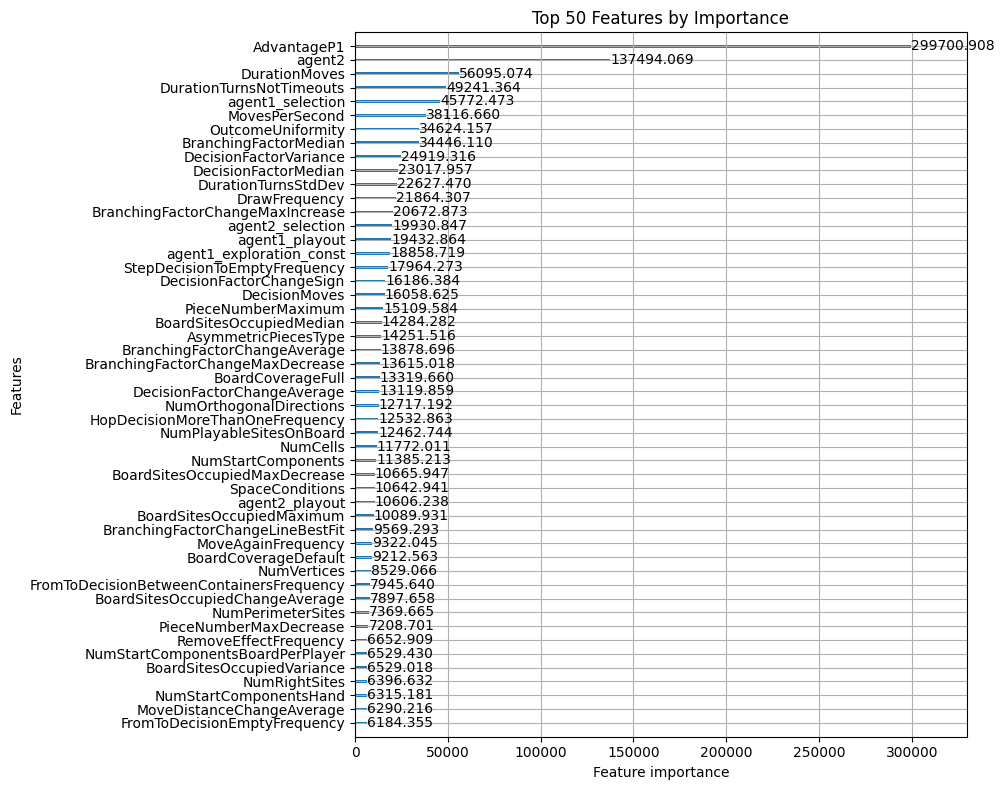

Fold 1 - RMSE: 0.4281871080023149
Fold 2


[100]	valid_0's rmse: 0.517515


[200]	valid_0's rmse: 0.496418


[300]	valid_0's rmse: 0.48617


[400]	valid_0's rmse: 0.476987


[500]	valid_0's rmse: 0.47148


[600]	valid_0's rmse: 0.467797


[700]	valid_0's rmse: 0.465153


[800]	valid_0's rmse: 0.463399


[900]	valid_0's rmse: 0.461801


[1000]	valid_0's rmse: 0.460422


[1100]	valid_0's rmse: 0.458974


[1200]	valid_0's rmse: 0.458078


[1300]	valid_0's rmse: 0.457122


[1400]	valid_0's rmse: 0.456192


[1500]	valid_0's rmse: 0.455444


[1600]	valid_0's rmse: 0.454711


[1700]	valid_0's rmse: 0.45411


[1800]	valid_0's rmse: 0.453628


[1900]	valid_0's rmse: 0.453044


[2000]	valid_0's rmse: 0.452598


[2100]	valid_0's rmse: 0.452078


[2200]	valid_0's rmse: 0.451555


[2300]	valid_0's rmse: 0.451062


[2400]	valid_0's rmse: 0.450616


[2500]	valid_0's rmse: 0.450288


[2600]	valid_0's rmse: 0.449955


[2700]	valid_0's rmse: 0.449443


[2800]	valid_0's rmse: 0.449158


[2900]	valid_0's rmse: 0.448776


[3000]	valid_0's rmse: 0.448552


[3100]	valid_0's rmse: 0.44826


[3200]	valid_0's rmse: 0.44806


[3300]	valid_0's rmse: 0.447783


[3400]	valid_0's rmse: 0.44759


[3500]	valid_0's rmse: 0.44739


[3600]	valid_0's rmse: 0.447194


[3700]	valid_0's rmse: 0.446998


[3800]	valid_0's rmse: 0.446707


[3900]	valid_0's rmse: 0.446582


[4000]	valid_0's rmse: 0.446478


[4100]	valid_0's rmse: 0.446379


[4200]	valid_0's rmse: 0.446191


[4300]	valid_0's rmse: 0.445949


[4400]	valid_0's rmse: 0.445661


[4500]	valid_0's rmse: 0.445496


[4600]	valid_0's rmse: 0.445328


[4700]	valid_0's rmse: 0.445179


[4800]	valid_0's rmse: 0.444951


[4900]	valid_0's rmse: 0.444706


[5000]	valid_0's rmse: 0.44462


[5100]	valid_0's rmse: 0.444371


[5200]	valid_0's rmse: 0.444274


[5300]	valid_0's rmse: 0.444156


[5400]	valid_0's rmse: 0.444046


[5500]	valid_0's rmse: 0.443815


[5600]	valid_0's rmse: 0.443699


[5700]	valid_0's rmse: 0.443583


[5800]	valid_0's rmse: 0.443436


[5900]	valid_0's rmse: 0.443343


[6000]	valid_0's rmse: 0.443282


[6100]	valid_0's rmse: 0.443176


[6200]	valid_0's rmse: 0.443067


[6300]	valid_0's rmse: 0.443022


[6400]	valid_0's rmse: 0.442935


[6500]	valid_0's rmse: 0.442835


[6600]	valid_0's rmse: 0.442765


[6700]	valid_0's rmse: 0.442655


[6800]	valid_0's rmse: 0.442607


[6900]	valid_0's rmse: 0.442507


[7000]	valid_0's rmse: 0.442486


[7100]	valid_0's rmse: 0.442413


[7200]	valid_0's rmse: 0.442325


[7300]	valid_0's rmse: 0.442234


[7400]	valid_0's rmse: 0.442234


[7500]	valid_0's rmse: 0.442167


[7600]	valid_0's rmse: 0.442004


[7700]	valid_0's rmse: 0.4419


[7800]	valid_0's rmse: 0.441814


[7900]	valid_0's rmse: 0.441736


[8000]	valid_0's rmse: 0.441681


[8100]	valid_0's rmse: 0.441553


[8200]	valid_0's rmse: 0.441558


[8300]	valid_0's rmse: 0.441499


[8400]	valid_0's rmse: 0.441429


[8500]	valid_0's rmse: 0.441326


[8600]	valid_0's rmse: 0.441255


[8700]	valid_0's rmse: 0.441187


[8800]	valid_0's rmse: 0.441134


[8900]	valid_0's rmse: 0.441029


[9000]	valid_0's rmse: 0.440957


[9100]	valid_0's rmse: 0.440977


[9200]	valid_0's rmse: 0.440937


[9300]	valid_0's rmse: 0.440905


[9400]	valid_0's rmse: 0.440921


[9500]	valid_0's rmse: 0.440855


[9600]	valid_0's rmse: 0.440791


[9700]	valid_0's rmse: 0.440702


[9800]	valid_0's rmse: 0.440668


[9900]	valid_0's rmse: 0.440613


[10000]	valid_0's rmse: 0.440591


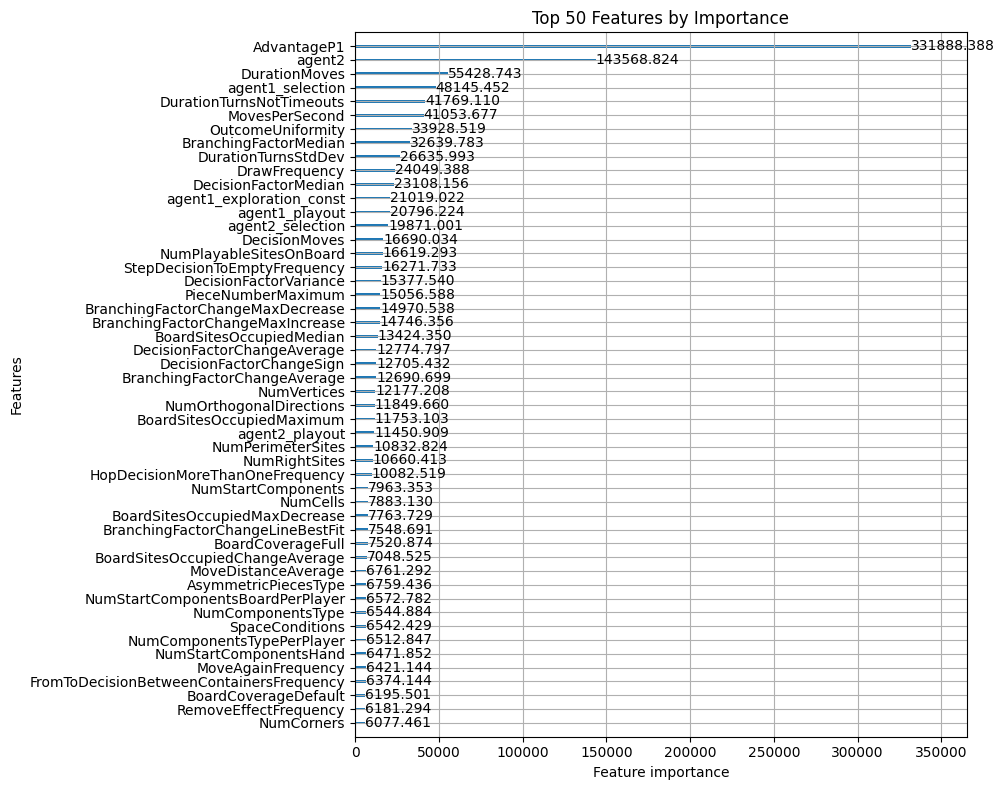

Fold 2 - RMSE: 0.44013363741349343
Fold 3


[100]	valid_0's rmse: 0.522119


[200]	valid_0's rmse: 0.49239


[300]	valid_0's rmse: 0.477519


[400]	valid_0's rmse: 0.469017


[500]	valid_0's rmse: 0.463437


[600]	valid_0's rmse: 0.460552


[700]	valid_0's rmse: 0.458334


[800]	valid_0's rmse: 0.456707


[900]	valid_0's rmse: 0.455031


[1000]	valid_0's rmse: 0.453322


[1100]	valid_0's rmse: 0.451839


[1200]	valid_0's rmse: 0.450993


[1300]	valid_0's rmse: 0.450098


[1400]	valid_0's rmse: 0.449096


[1500]	valid_0's rmse: 0.448393


[1600]	valid_0's rmse: 0.447852


[1700]	valid_0's rmse: 0.44719


[1800]	valid_0's rmse: 0.44666


[1900]	valid_0's rmse: 0.446155


[2000]	valid_0's rmse: 0.445734


[2100]	valid_0's rmse: 0.445078


[2200]	valid_0's rmse: 0.444516


[2300]	valid_0's rmse: 0.444334


[2400]	valid_0's rmse: 0.444039


[2500]	valid_0's rmse: 0.44375


[2600]	valid_0's rmse: 0.44345


[2700]	valid_0's rmse: 0.443115


[2800]	valid_0's rmse: 0.442791


[2900]	valid_0's rmse: 0.442507


[3000]	valid_0's rmse: 0.442171


[3100]	valid_0's rmse: 0.441829


[3200]	valid_0's rmse: 0.441631


[3300]	valid_0's rmse: 0.441377


[3400]	valid_0's rmse: 0.44117


[3500]	valid_0's rmse: 0.440845


[3600]	valid_0's rmse: 0.4406


[3700]	valid_0's rmse: 0.440285


[3800]	valid_0's rmse: 0.440006


[3900]	valid_0's rmse: 0.439806


[4000]	valid_0's rmse: 0.439502


[4100]	valid_0's rmse: 0.439369


[4200]	valid_0's rmse: 0.439277


[4300]	valid_0's rmse: 0.439169


[4400]	valid_0's rmse: 0.438952


[4500]	valid_0's rmse: 0.438781


[4600]	valid_0's rmse: 0.438596


[4700]	valid_0's rmse: 0.43842


[4800]	valid_0's rmse: 0.438277


[4900]	valid_0's rmse: 0.438205


[5000]	valid_0's rmse: 0.438058


[5100]	valid_0's rmse: 0.437982


[5200]	valid_0's rmse: 0.437842


[5300]	valid_0's rmse: 0.437783


[5400]	valid_0's rmse: 0.437618


[5500]	valid_0's rmse: 0.437472


[5600]	valid_0's rmse: 0.437455


[5700]	valid_0's rmse: 0.437383


[5800]	valid_0's rmse: 0.437274


[5900]	valid_0's rmse: 0.437113


[6000]	valid_0's rmse: 0.437055


[6100]	valid_0's rmse: 0.436979


[6200]	valid_0's rmse: 0.43695


[6300]	valid_0's rmse: 0.436909


[6400]	valid_0's rmse: 0.436756


[6500]	valid_0's rmse: 0.436738


[6600]	valid_0's rmse: 0.436629


[6700]	valid_0's rmse: 0.436529


[6800]	valid_0's rmse: 0.436478


[6900]	valid_0's rmse: 0.436414


[7000]	valid_0's rmse: 0.436274


[7100]	valid_0's rmse: 0.436205


[7200]	valid_0's rmse: 0.436173


[7300]	valid_0's rmse: 0.436147


[7400]	valid_0's rmse: 0.436205


[7500]	valid_0's rmse: 0.436198


[7600]	valid_0's rmse: 0.43615


[7700]	valid_0's rmse: 0.436184


[7800]	valid_0's rmse: 0.436121


[7900]	valid_0's rmse: 0.436039


[8000]	valid_0's rmse: 0.436022


[8100]	valid_0's rmse: 0.435969


[8200]	valid_0's rmse: 0.435934


[8300]	valid_0's rmse: 0.435939


[8400]	valid_0's rmse: 0.43588


[8500]	valid_0's rmse: 0.43577


[8600]	valid_0's rmse: 0.435703


[8700]	valid_0's rmse: 0.435685


[8800]	valid_0's rmse: 0.435667


[8900]	valid_0's rmse: 0.435629


[9000]	valid_0's rmse: 0.435517


[9100]	valid_0's rmse: 0.435496


[9200]	valid_0's rmse: 0.435428


[9300]	valid_0's rmse: 0.435426


[9400]	valid_0's rmse: 0.435331


[9500]	valid_0's rmse: 0.435312


[9600]	valid_0's rmse: 0.435297


[9700]	valid_0's rmse: 0.435262


[9800]	valid_0's rmse: 0.435255


[9900]	valid_0's rmse: 0.435251


[10000]	valid_0's rmse: 0.435215


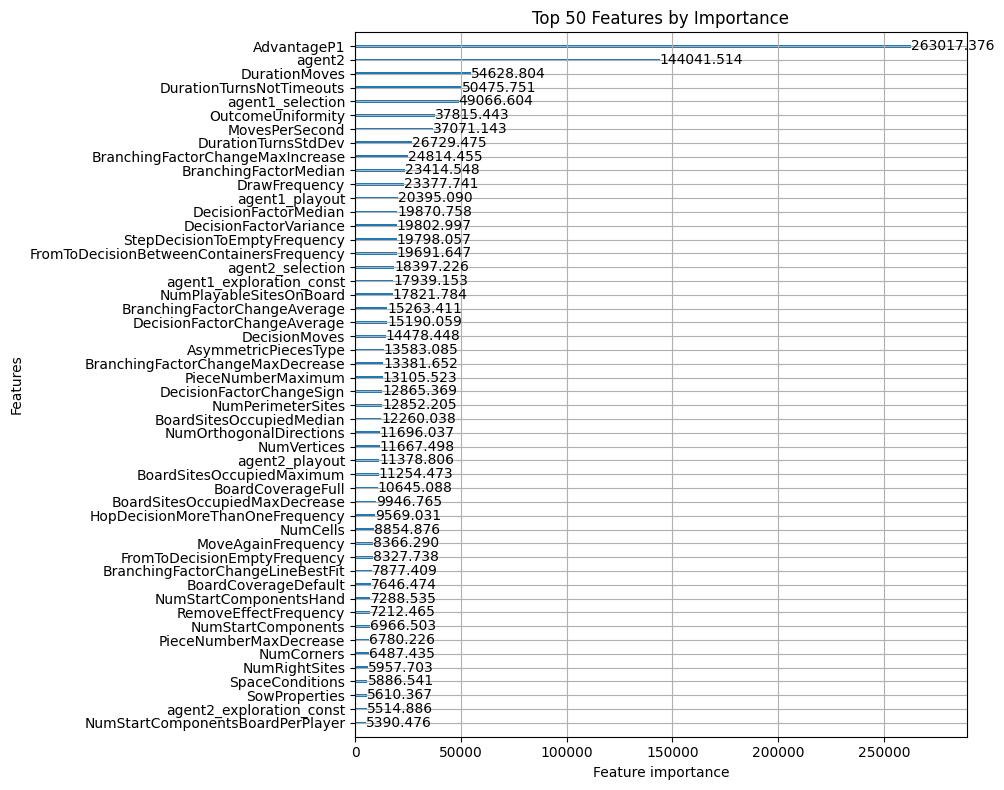

Fold 3 - RMSE: 0.4344868854848341
Fold 4


[100]	valid_0's rmse: 0.517543


[200]	valid_0's rmse: 0.493297


[300]	valid_0's rmse: 0.479302


[400]	valid_0's rmse: 0.469553


[500]	valid_0's rmse: 0.464073


[600]	valid_0's rmse: 0.46045


[700]	valid_0's rmse: 0.457723


[800]	valid_0's rmse: 0.455581


[900]	valid_0's rmse: 0.453452


[1000]	valid_0's rmse: 0.451926


[1100]	valid_0's rmse: 0.450197


[1200]	valid_0's rmse: 0.448948


[1300]	valid_0's rmse: 0.447814


[1400]	valid_0's rmse: 0.446732


[1500]	valid_0's rmse: 0.445641


[1600]	valid_0's rmse: 0.444804


[1700]	valid_0's rmse: 0.444057


[1800]	valid_0's rmse: 0.443352


[1900]	valid_0's rmse: 0.442688


[2000]	valid_0's rmse: 0.442022


[2100]	valid_0's rmse: 0.441432


[2200]	valid_0's rmse: 0.440947


[2300]	valid_0's rmse: 0.440505


[2400]	valid_0's rmse: 0.440134


[2500]	valid_0's rmse: 0.439682


[2600]	valid_0's rmse: 0.439317


[2700]	valid_0's rmse: 0.438903


[2800]	valid_0's rmse: 0.438487


[2900]	valid_0's rmse: 0.438187


[3000]	valid_0's rmse: 0.437874


[3100]	valid_0's rmse: 0.437623


[3200]	valid_0's rmse: 0.437336


[3300]	valid_0's rmse: 0.437041


[3400]	valid_0's rmse: 0.436778


[3500]	valid_0's rmse: 0.436626


[3600]	valid_0's rmse: 0.436378


[3700]	valid_0's rmse: 0.4363


[3800]	valid_0's rmse: 0.435979


[3900]	valid_0's rmse: 0.435698


[4000]	valid_0's rmse: 0.43552


[4100]	valid_0's rmse: 0.43535


[4200]	valid_0's rmse: 0.435253


[4300]	valid_0's rmse: 0.435086


[4400]	valid_0's rmse: 0.43495


[4500]	valid_0's rmse: 0.434781


[4600]	valid_0's rmse: 0.434649


[4700]	valid_0's rmse: 0.434566


[4800]	valid_0's rmse: 0.434342


[4900]	valid_0's rmse: 0.434167


[5000]	valid_0's rmse: 0.434067


[5100]	valid_0's rmse: 0.433835


[5200]	valid_0's rmse: 0.433726


[5300]	valid_0's rmse: 0.433636


[5400]	valid_0's rmse: 0.433543


[5500]	valid_0's rmse: 0.433429


[5600]	valid_0's rmse: 0.433355


[5700]	valid_0's rmse: 0.43332


[5800]	valid_0's rmse: 0.433209


[5900]	valid_0's rmse: 0.433089


[6000]	valid_0's rmse: 0.432902


[6100]	valid_0's rmse: 0.432876


[6200]	valid_0's rmse: 0.432791


[6300]	valid_0's rmse: 0.432711


[6400]	valid_0's rmse: 0.432642


[6500]	valid_0's rmse: 0.432623


[6600]	valid_0's rmse: 0.432512


[6700]	valid_0's rmse: 0.432477


[6800]	valid_0's rmse: 0.432448


[6900]	valid_0's rmse: 0.432364


[7000]	valid_0's rmse: 0.4322


[7100]	valid_0's rmse: 0.432153


[7200]	valid_0's rmse: 0.43211


[7300]	valid_0's rmse: 0.432107


[7400]	valid_0's rmse: 0.432009


[7500]	valid_0's rmse: 0.431925


[7600]	valid_0's rmse: 0.431957


[7700]	valid_0's rmse: 0.43197


[7800]	valid_0's rmse: 0.431889


[7900]	valid_0's rmse: 0.431856


[8000]	valid_0's rmse: 0.431764


[8100]	valid_0's rmse: 0.431676


[8200]	valid_0's rmse: 0.431595


[8300]	valid_0's rmse: 0.431584


[8400]	valid_0's rmse: 0.43155


[8500]	valid_0's rmse: 0.431479


[8600]	valid_0's rmse: 0.431483


[8700]	valid_0's rmse: 0.431379


[8800]	valid_0's rmse: 0.431336


[8900]	valid_0's rmse: 0.431289


[9000]	valid_0's rmse: 0.431198


[9100]	valid_0's rmse: 0.431123


[9200]	valid_0's rmse: 0.431096


[9300]	valid_0's rmse: 0.431055


[9400]	valid_0's rmse: 0.431054


[9500]	valid_0's rmse: 0.430996


[9600]	valid_0's rmse: 0.430896


[9700]	valid_0's rmse: 0.430828


[9800]	valid_0's rmse: 0.43087


[9900]	valid_0's rmse: 0.430848


[10000]	valid_0's rmse: 0.430789


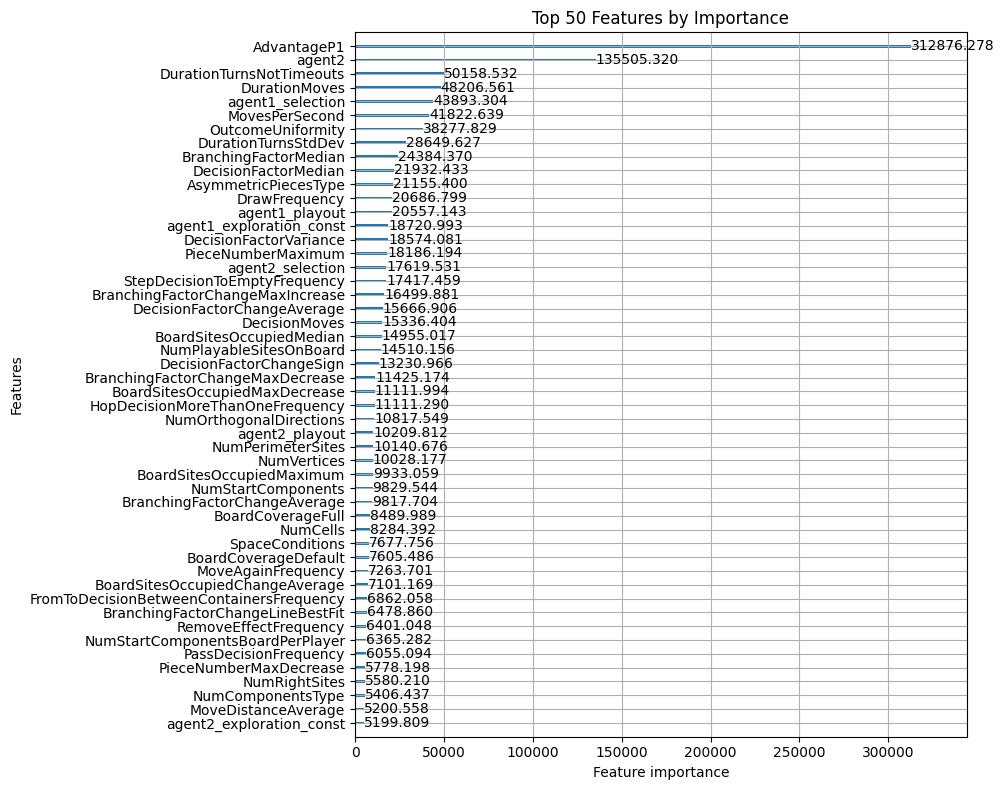

Fold 4 - RMSE: 0.4300218133654331
Fold 5


[100]	valid_0's rmse: 0.489117


[200]	valid_0's rmse: 0.46491


[300]	valid_0's rmse: 0.451435


[400]	valid_0's rmse: 0.442152


[500]	valid_0's rmse: 0.436275


[600]	valid_0's rmse: 0.43289


[700]	valid_0's rmse: 0.430632


[800]	valid_0's rmse: 0.428759


[900]	valid_0's rmse: 0.426821


[1000]	valid_0's rmse: 0.425361


[1100]	valid_0's rmse: 0.423867


[1200]	valid_0's rmse: 0.422513


[1300]	valid_0's rmse: 0.421521


[1400]	valid_0's rmse: 0.420236


[1500]	valid_0's rmse: 0.419151


[1600]	valid_0's rmse: 0.418376


[1700]	valid_0's rmse: 0.417491


[1800]	valid_0's rmse: 0.416702


[1900]	valid_0's rmse: 0.416047


[2000]	valid_0's rmse: 0.415348


[2100]	valid_0's rmse: 0.4146


[2200]	valid_0's rmse: 0.41385


[2300]	valid_0's rmse: 0.413321


[2400]	valid_0's rmse: 0.412732


[2500]	valid_0's rmse: 0.412288


[2600]	valid_0's rmse: 0.411917


[2700]	valid_0's rmse: 0.411487


[2800]	valid_0's rmse: 0.411134


[2900]	valid_0's rmse: 0.410848


[3000]	valid_0's rmse: 0.410538


[3100]	valid_0's rmse: 0.41022


[3200]	valid_0's rmse: 0.409967


[3300]	valid_0's rmse: 0.409688


[3400]	valid_0's rmse: 0.409485


[3500]	valid_0's rmse: 0.409267


[3600]	valid_0's rmse: 0.409081


[3700]	valid_0's rmse: 0.40873


[3800]	valid_0's rmse: 0.408431


[3900]	valid_0's rmse: 0.408252


[4000]	valid_0's rmse: 0.408089


[4100]	valid_0's rmse: 0.407981


[4200]	valid_0's rmse: 0.407724


[4300]	valid_0's rmse: 0.407601


[4400]	valid_0's rmse: 0.407361


[4500]	valid_0's rmse: 0.407209


[4600]	valid_0's rmse: 0.40697


[4700]	valid_0's rmse: 0.40681


[4800]	valid_0's rmse: 0.406651


[4900]	valid_0's rmse: 0.40648


[5000]	valid_0's rmse: 0.406292


[5100]	valid_0's rmse: 0.406298


[5200]	valid_0's rmse: 0.406102


[5300]	valid_0's rmse: 0.406052


[5400]	valid_0's rmse: 0.405968


[5500]	valid_0's rmse: 0.405922


[5600]	valid_0's rmse: 0.405781


[5700]	valid_0's rmse: 0.405637


[5800]	valid_0's rmse: 0.405531


[5900]	valid_0's rmse: 0.405386


[6000]	valid_0's rmse: 0.405257


[6100]	valid_0's rmse: 0.405108


[6200]	valid_0's rmse: 0.405074


[6300]	valid_0's rmse: 0.404873


[6400]	valid_0's rmse: 0.404808


[6500]	valid_0's rmse: 0.404812


[6600]	valid_0's rmse: 0.404799


[6700]	valid_0's rmse: 0.404712


[6800]	valid_0's rmse: 0.404621


[6900]	valid_0's rmse: 0.404567


[7000]	valid_0's rmse: 0.404524


[7100]	valid_0's rmse: 0.404444


[7200]	valid_0's rmse: 0.40441


[7300]	valid_0's rmse: 0.404387


[7400]	valid_0's rmse: 0.404324


[7500]	valid_0's rmse: 0.404299


[7600]	valid_0's rmse: 0.404329


[7700]	valid_0's rmse: 0.40431


[7800]	valid_0's rmse: 0.404226


[7900]	valid_0's rmse: 0.404122


[8000]	valid_0's rmse: 0.404044


[8100]	valid_0's rmse: 0.403971


[8200]	valid_0's rmse: 0.403973


[8300]	valid_0's rmse: 0.403953


[8400]	valid_0's rmse: 0.403879


[8500]	valid_0's rmse: 0.403785


[8600]	valid_0's rmse: 0.403713


[8700]	valid_0's rmse: 0.403755


[8800]	valid_0's rmse: 0.40371


[8900]	valid_0's rmse: 0.403731


[9000]	valid_0's rmse: 0.403722


[9100]	valid_0's rmse: 0.403709


[9200]	valid_0's rmse: 0.403676


[9300]	valid_0's rmse: 0.403596


[9400]	valid_0's rmse: 0.403567


[9500]	valid_0's rmse: 0.403565


[9600]	valid_0's rmse: 0.403506


[9700]	valid_0's rmse: 0.403427


[9800]	valid_0's rmse: 0.403421


[9900]	valid_0's rmse: 0.403319


[10000]	valid_0's rmse: 0.403304


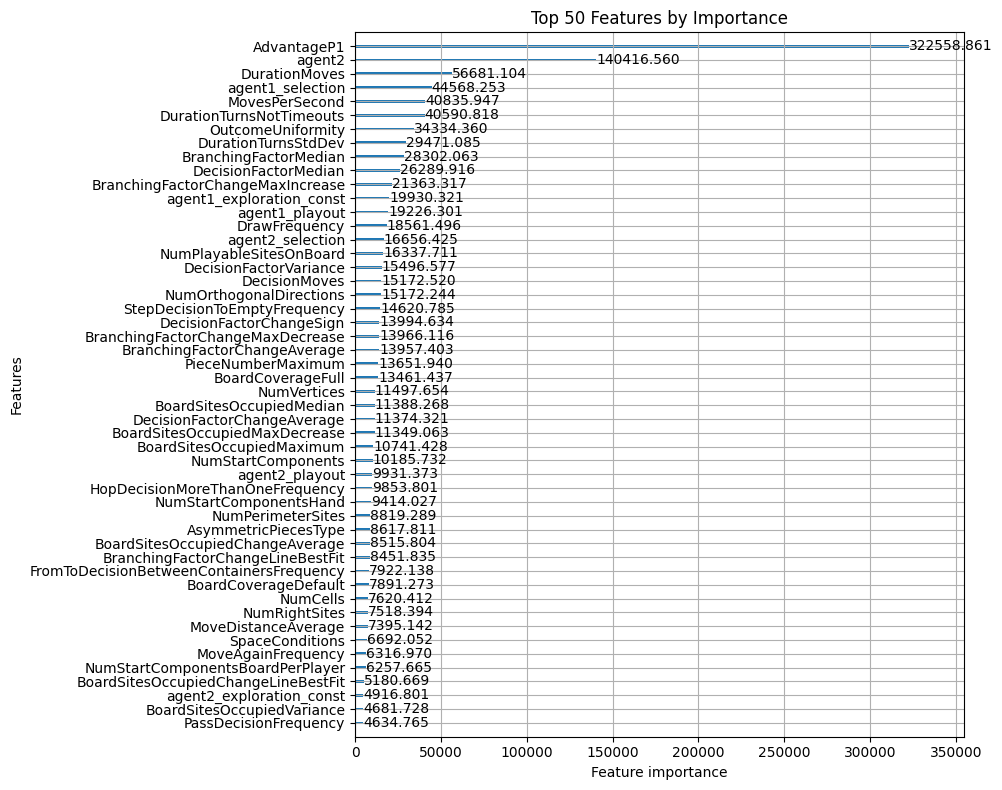

Fold 5 - RMSE: 0.4028358507740594
List of oof scores: [0.4281871080023149, 0.44013363741349343, 0.4344868854848341, 0.4300218133654331, 0.4028358507740594]
Average oof score: 0.427133059008027


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.488266


[200]	valid_0's rmse: 0.467418


[300]	valid_0's rmse: 0.455031


[400]	valid_0's rmse: 0.44838


[500]	valid_0's rmse: 0.444274


[600]	valid_0's rmse: 0.441517


[700]	valid_0's rmse: 0.439091


[800]	valid_0's rmse: 0.437468


[900]	valid_0's rmse: 0.435734


[1000]	valid_0's rmse: 0.434455


[1100]	valid_0's rmse: 0.433143


[1200]	valid_0's rmse: 0.432048


[1300]	valid_0's rmse: 0.431118


[1400]	valid_0's rmse: 0.430337


[1500]	valid_0's rmse: 0.429778


[1600]	valid_0's rmse: 0.42919


[1700]	valid_0's rmse: 0.428604


[1800]	valid_0's rmse: 0.428038


[1900]	valid_0's rmse: 0.427411


[2000]	valid_0's rmse: 0.426917


[2100]	valid_0's rmse: 0.426526


[2200]	valid_0's rmse: 0.426205


[2300]	valid_0's rmse: 0.426041


[2400]	valid_0's rmse: 0.425612


[2500]	valid_0's rmse: 0.425305


[2600]	valid_0's rmse: 0.42497


[2700]	valid_0's rmse: 0.424623


[2800]	valid_0's rmse: 0.424227


[2900]	valid_0's rmse: 0.423933


[3000]	valid_0's rmse: 0.42366


[3100]	valid_0's rmse: 0.423403


[3200]	valid_0's rmse: 0.423084


[3300]	valid_0's rmse: 0.422728


[3400]	valid_0's rmse: 0.422508


[3500]	valid_0's rmse: 0.422358


[3600]	valid_0's rmse: 0.422104


[3700]	valid_0's rmse: 0.421968


[3800]	valid_0's rmse: 0.421779


[3900]	valid_0's rmse: 0.421514


[4000]	valid_0's rmse: 0.421304


[4100]	valid_0's rmse: 0.421213


[4200]	valid_0's rmse: 0.421022


[4300]	valid_0's rmse: 0.420916


[4400]	valid_0's rmse: 0.420727


[4500]	valid_0's rmse: 0.420572


[4600]	valid_0's rmse: 0.420358


[4700]	valid_0's rmse: 0.420193


[4800]	valid_0's rmse: 0.420055


[4900]	valid_0's rmse: 0.419991


[5000]	valid_0's rmse: 0.419815


[5100]	valid_0's rmse: 0.419756


[5200]	valid_0's rmse: 0.419691


[5300]	valid_0's rmse: 0.419533


[5400]	valid_0's rmse: 0.419402


[5500]	valid_0's rmse: 0.419258


[5600]	valid_0's rmse: 0.419147


[5700]	valid_0's rmse: 0.41899


[5800]	valid_0's rmse: 0.418836


[5900]	valid_0's rmse: 0.418745


[6000]	valid_0's rmse: 0.41865


[6100]	valid_0's rmse: 0.418595


[6200]	valid_0's rmse: 0.418482


[6300]	valid_0's rmse: 0.418422


[6400]	valid_0's rmse: 0.418355


[6500]	valid_0's rmse: 0.418302


[6600]	valid_0's rmse: 0.418236


[6700]	valid_0's rmse: 0.418101


[6800]	valid_0's rmse: 0.417988


[6900]	valid_0's rmse: 0.417857


[7000]	valid_0's rmse: 0.417838


[7100]	valid_0's rmse: 0.417822


[7200]	valid_0's rmse: 0.417804


[7300]	valid_0's rmse: 0.4176


[7400]	valid_0's rmse: 0.41759


[7500]	valid_0's rmse: 0.417592


[7600]	valid_0's rmse: 0.417586


[7700]	valid_0's rmse: 0.41749


[7800]	valid_0's rmse: 0.417428


[7900]	valid_0's rmse: 0.417373


[8000]	valid_0's rmse: 0.417351


[8100]	valid_0's rmse: 0.417308


[8200]	valid_0's rmse: 0.417228


[8300]	valid_0's rmse: 0.417217


[8400]	valid_0's rmse: 0.417179


[8500]	valid_0's rmse: 0.41709


[8600]	valid_0's rmse: 0.417067


[8700]	valid_0's rmse: 0.416988


[8800]	valid_0's rmse: 0.416966


[8900]	valid_0's rmse: 0.416982


[9000]	valid_0's rmse: 0.416937


[9100]	valid_0's rmse: 0.416912


[9200]	valid_0's rmse: 0.416844


[9300]	valid_0's rmse: 0.416826


[9400]	valid_0's rmse: 0.41683


[9500]	valid_0's rmse: 0.416822


[9600]	valid_0's rmse: 0.416774


[9700]	valid_0's rmse: 0.416747


[9800]	valid_0's rmse: 0.416693


[9900]	valid_0's rmse: 0.416669


[10000]	valid_0's rmse: 0.416651


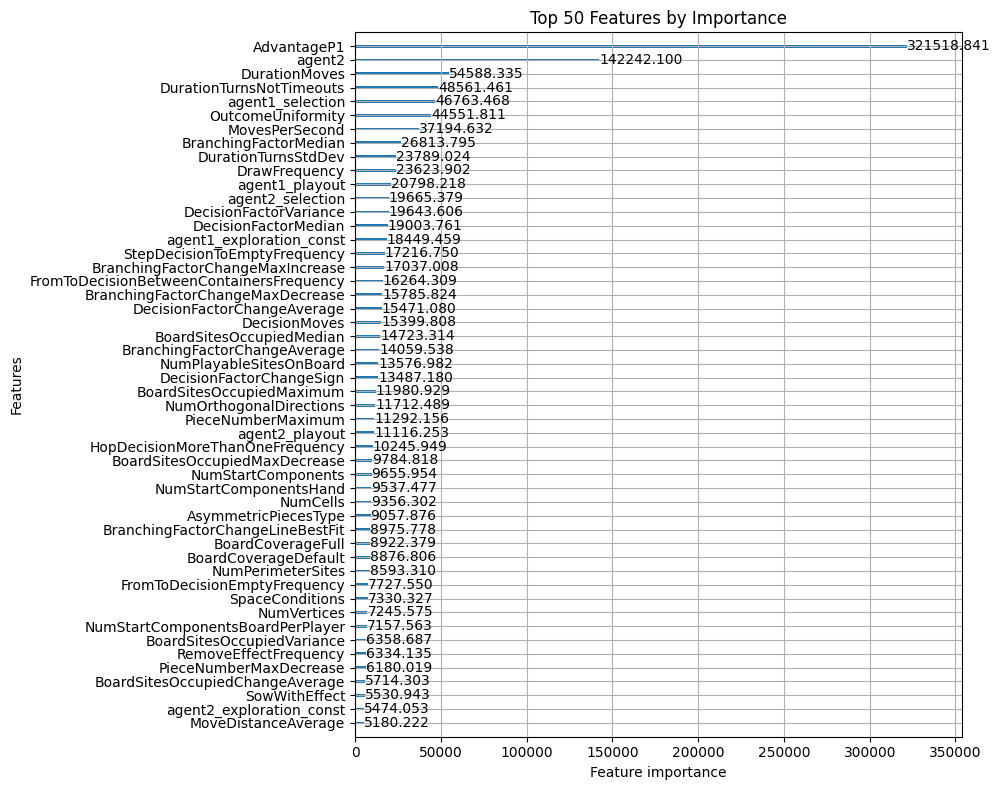

Fold 1 - RMSE: 0.41621179450543005
Fold 2


[100]	valid_0's rmse: 0.468847


[200]	valid_0's rmse: 0.445615


[300]	valid_0's rmse: 0.433965


[400]	valid_0's rmse: 0.426346


[500]	valid_0's rmse: 0.422055


[600]	valid_0's rmse: 0.419483


[700]	valid_0's rmse: 0.417452


[800]	valid_0's rmse: 0.416322


[900]	valid_0's rmse: 0.415107


[1000]	valid_0's rmse: 0.413964


[1100]	valid_0's rmse: 0.413041


[1200]	valid_0's rmse: 0.412138


[1300]	valid_0's rmse: 0.411266


[1400]	valid_0's rmse: 0.410619


[1500]	valid_0's rmse: 0.409963


[1600]	valid_0's rmse: 0.409457


[1700]	valid_0's rmse: 0.409005


[1800]	valid_0's rmse: 0.408631


[1900]	valid_0's rmse: 0.408215


[2000]	valid_0's rmse: 0.407902


[2100]	valid_0's rmse: 0.407485


[2200]	valid_0's rmse: 0.407112


[2300]	valid_0's rmse: 0.406926


[2400]	valid_0's rmse: 0.406426


[2500]	valid_0's rmse: 0.406135


[2600]	valid_0's rmse: 0.405852


[2700]	valid_0's rmse: 0.405558


[2800]	valid_0's rmse: 0.405306


[2900]	valid_0's rmse: 0.405152


[3000]	valid_0's rmse: 0.404965


[3100]	valid_0's rmse: 0.40482


[3200]	valid_0's rmse: 0.404661


[3300]	valid_0's rmse: 0.404398


[3400]	valid_0's rmse: 0.404246


[3500]	valid_0's rmse: 0.404101


[3600]	valid_0's rmse: 0.40408


[3700]	valid_0's rmse: 0.403909


[3800]	valid_0's rmse: 0.403789


[3900]	valid_0's rmse: 0.403697


[4000]	valid_0's rmse: 0.403528


[4100]	valid_0's rmse: 0.403381


[4200]	valid_0's rmse: 0.403302


[4300]	valid_0's rmse: 0.403149


[4400]	valid_0's rmse: 0.403089


[4500]	valid_0's rmse: 0.403092


[4600]	valid_0's rmse: 0.403085


[4700]	valid_0's rmse: 0.402987


[4800]	valid_0's rmse: 0.402898


[4900]	valid_0's rmse: 0.402787


[5000]	valid_0's rmse: 0.402732


[5100]	valid_0's rmse: 0.402694


[5200]	valid_0's rmse: 0.4027


[5300]	valid_0's rmse: 0.402594


[5400]	valid_0's rmse: 0.402485


[5500]	valid_0's rmse: 0.402437


[5600]	valid_0's rmse: 0.40246


[5700]	valid_0's rmse: 0.40242


[5800]	valid_0's rmse: 0.4024


[5900]	valid_0's rmse: 0.402364


[6000]	valid_0's rmse: 0.402317


[6100]	valid_0's rmse: 0.402265


[6200]	valid_0's rmse: 0.402232


[6300]	valid_0's rmse: 0.402192


[6400]	valid_0's rmse: 0.402217


[6500]	valid_0's rmse: 0.402194


[6600]	valid_0's rmse: 0.402188


[6700]	valid_0's rmse: 0.402157


[6800]	valid_0's rmse: 0.402202


[6900]	valid_0's rmse: 0.402207


[7000]	valid_0's rmse: 0.402196


[7100]	valid_0's rmse: 0.402144


[7200]	valid_0's rmse: 0.402164


[7300]	valid_0's rmse: 0.402156


[7400]	valid_0's rmse: 0.402173


[7500]	valid_0's rmse: 0.402118


[7600]	valid_0's rmse: 0.40204


[7700]	valid_0's rmse: 0.401999


[7800]	valid_0's rmse: 0.40194


[7900]	valid_0's rmse: 0.401874


[8000]	valid_0's rmse: 0.401905


[8100]	valid_0's rmse: 0.401923


[8200]	valid_0's rmse: 0.401964


[8300]	valid_0's rmse: 0.401985


[8400]	valid_0's rmse: 0.401941


[8500]	valid_0's rmse: 0.401877


[8600]	valid_0's rmse: 0.401919


[8700]	valid_0's rmse: 0.401938


[8800]	valid_0's rmse: 0.40194


[8900]	valid_0's rmse: 0.401981


[9000]	valid_0's rmse: 0.401996


[9100]	valid_0's rmse: 0.402079


[9200]	valid_0's rmse: 0.402035


[9300]	valid_0's rmse: 0.402063


[9400]	valid_0's rmse: 0.402034


[9500]	valid_0's rmse: 0.402015


[9600]	valid_0's rmse: 0.402025


[9700]	valid_0's rmse: 0.401984


[9800]	valid_0's rmse: 0.401984


[9900]	valid_0's rmse: 0.402035


[10000]	valid_0's rmse: 0.402071


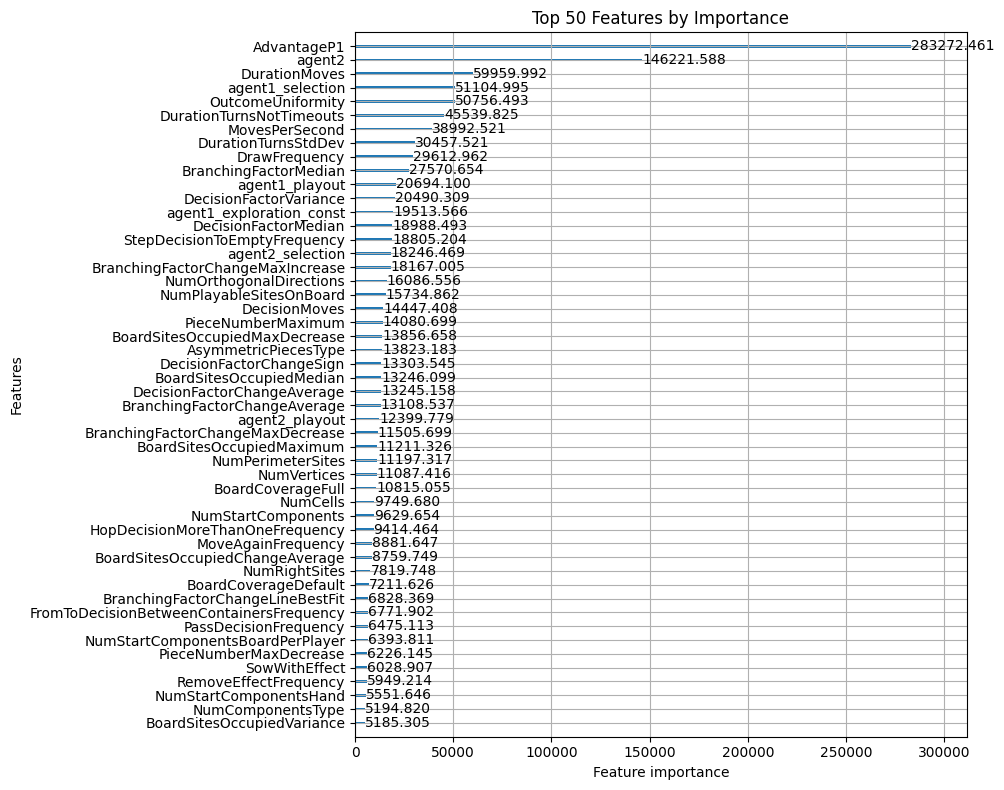

Fold 2 - RMSE: 0.4014732283394731
Fold 3


[100]	valid_0's rmse: 0.533642


[200]	valid_0's rmse: 0.50434


[300]	valid_0's rmse: 0.487599


[400]	valid_0's rmse: 0.478115


[500]	valid_0's rmse: 0.471992


[600]	valid_0's rmse: 0.468709


[700]	valid_0's rmse: 0.465763


[800]	valid_0's rmse: 0.462795


[900]	valid_0's rmse: 0.460452


[1000]	valid_0's rmse: 0.45851


[1100]	valid_0's rmse: 0.456837


[1200]	valid_0's rmse: 0.45547


[1300]	valid_0's rmse: 0.454151


[1400]	valid_0's rmse: 0.45304


[1500]	valid_0's rmse: 0.451978


[1600]	valid_0's rmse: 0.451171


[1700]	valid_0's rmse: 0.450424


[1800]	valid_0's rmse: 0.449476


[1900]	valid_0's rmse: 0.448763


[2000]	valid_0's rmse: 0.448008


[2100]	valid_0's rmse: 0.447302


[2200]	valid_0's rmse: 0.446645


[2300]	valid_0's rmse: 0.446115


[2400]	valid_0's rmse: 0.445635


[2500]	valid_0's rmse: 0.445268


[2600]	valid_0's rmse: 0.444866


[2700]	valid_0's rmse: 0.444476


[2800]	valid_0's rmse: 0.44416


[2900]	valid_0's rmse: 0.443751


[3000]	valid_0's rmse: 0.443416


[3100]	valid_0's rmse: 0.443162


[3200]	valid_0's rmse: 0.442974


[3300]	valid_0's rmse: 0.442778


[3400]	valid_0's rmse: 0.442506


[3500]	valid_0's rmse: 0.442191


[3600]	valid_0's rmse: 0.441901


[3700]	valid_0's rmse: 0.441599


[3800]	valid_0's rmse: 0.44123


[3900]	valid_0's rmse: 0.441046


[4000]	valid_0's rmse: 0.440803


[4100]	valid_0's rmse: 0.440558


[4200]	valid_0's rmse: 0.440486


[4300]	valid_0's rmse: 0.440261


[4400]	valid_0's rmse: 0.440089


[4500]	valid_0's rmse: 0.439938


[4600]	valid_0's rmse: 0.43982


[4700]	valid_0's rmse: 0.439642


[4800]	valid_0's rmse: 0.439496


[4900]	valid_0's rmse: 0.439441


[5000]	valid_0's rmse: 0.439235


[5100]	valid_0's rmse: 0.439061


[5200]	valid_0's rmse: 0.438959


[5300]	valid_0's rmse: 0.438778


[5400]	valid_0's rmse: 0.438691


[5500]	valid_0's rmse: 0.438499


[5600]	valid_0's rmse: 0.438334


[5700]	valid_0's rmse: 0.438138


[5800]	valid_0's rmse: 0.438105


[5900]	valid_0's rmse: 0.437996


[6000]	valid_0's rmse: 0.437921


[6100]	valid_0's rmse: 0.437753


[6200]	valid_0's rmse: 0.437676


[6300]	valid_0's rmse: 0.43748


[6400]	valid_0's rmse: 0.437395


[6500]	valid_0's rmse: 0.437364


[6600]	valid_0's rmse: 0.437243


[6700]	valid_0's rmse: 0.437099


[6800]	valid_0's rmse: 0.436992


[6900]	valid_0's rmse: 0.436919


[7000]	valid_0's rmse: 0.436864


[7100]	valid_0's rmse: 0.436745


[7200]	valid_0's rmse: 0.436683


[7300]	valid_0's rmse: 0.436598


[7400]	valid_0's rmse: 0.436532


[7500]	valid_0's rmse: 0.436517


[7600]	valid_0's rmse: 0.436395


[7700]	valid_0's rmse: 0.436314


[7800]	valid_0's rmse: 0.436201


[7900]	valid_0's rmse: 0.436123


[8000]	valid_0's rmse: 0.436086


[8100]	valid_0's rmse: 0.436026


[8200]	valid_0's rmse: 0.435944


[8300]	valid_0's rmse: 0.435933


[8400]	valid_0's rmse: 0.435913


[8500]	valid_0's rmse: 0.435898


[8600]	valid_0's rmse: 0.435893


[8700]	valid_0's rmse: 0.435813


[8800]	valid_0's rmse: 0.435718


[8900]	valid_0's rmse: 0.435745


[9000]	valid_0's rmse: 0.435669


[9100]	valid_0's rmse: 0.435644


[9200]	valid_0's rmse: 0.435549


[9300]	valid_0's rmse: 0.435486


[9400]	valid_0's rmse: 0.435476


[9500]	valid_0's rmse: 0.435405


[9600]	valid_0's rmse: 0.435411


[9700]	valid_0's rmse: 0.43533


[9800]	valid_0's rmse: 0.435277


[9900]	valid_0's rmse: 0.435188


[10000]	valid_0's rmse: 0.43516


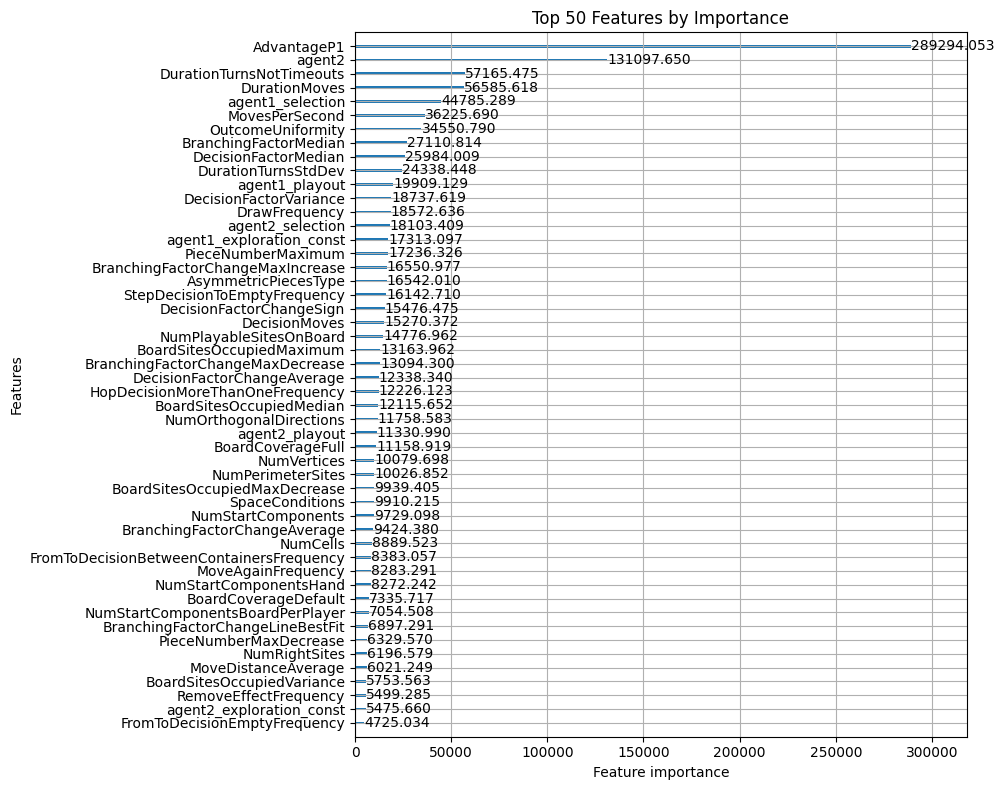

Fold 3 - RMSE: 0.4345446390648151
Fold 4


[100]	valid_0's rmse: 0.523627


[200]	valid_0's rmse: 0.497767


[300]	valid_0's rmse: 0.482672


[400]	valid_0's rmse: 0.475293


[500]	valid_0's rmse: 0.470311


[600]	valid_0's rmse: 0.467257


[700]	valid_0's rmse: 0.464912


[800]	valid_0's rmse: 0.462613


[900]	valid_0's rmse: 0.460698


[1000]	valid_0's rmse: 0.459115


[1100]	valid_0's rmse: 0.457873


[1200]	valid_0's rmse: 0.456843


[1300]	valid_0's rmse: 0.455774


[1400]	valid_0's rmse: 0.455044


[1500]	valid_0's rmse: 0.454163


[1600]	valid_0's rmse: 0.45337


[1700]	valid_0's rmse: 0.45277


[1800]	valid_0's rmse: 0.45195


[1900]	valid_0's rmse: 0.451447


[2000]	valid_0's rmse: 0.450773


[2100]	valid_0's rmse: 0.450375


[2200]	valid_0's rmse: 0.44997


[2300]	valid_0's rmse: 0.449548


[2400]	valid_0's rmse: 0.449214


[2500]	valid_0's rmse: 0.448977


[2600]	valid_0's rmse: 0.448541


[2700]	valid_0's rmse: 0.448161


[2800]	valid_0's rmse: 0.447797


[2900]	valid_0's rmse: 0.447487


[3000]	valid_0's rmse: 0.447282


[3100]	valid_0's rmse: 0.447091


[3200]	valid_0's rmse: 0.446735


[3300]	valid_0's rmse: 0.446242


[3400]	valid_0's rmse: 0.445967


[3500]	valid_0's rmse: 0.445751


[3600]	valid_0's rmse: 0.445595


[3700]	valid_0's rmse: 0.445362


[3800]	valid_0's rmse: 0.445076


[3900]	valid_0's rmse: 0.444909


[4000]	valid_0's rmse: 0.444705


[4100]	valid_0's rmse: 0.444408


[4200]	valid_0's rmse: 0.444262


[4300]	valid_0's rmse: 0.444197


[4400]	valid_0's rmse: 0.444


[4500]	valid_0's rmse: 0.443837


[4600]	valid_0's rmse: 0.443708


[4700]	valid_0's rmse: 0.44361


[4800]	valid_0's rmse: 0.44344


[4900]	valid_0's rmse: 0.443421


[5000]	valid_0's rmse: 0.443218


[5100]	valid_0's rmse: 0.443119


[5200]	valid_0's rmse: 0.442865


[5300]	valid_0's rmse: 0.44265


[5400]	valid_0's rmse: 0.442586


[5500]	valid_0's rmse: 0.442456


[5600]	valid_0's rmse: 0.442383


[5700]	valid_0's rmse: 0.442205


[5800]	valid_0's rmse: 0.442094


[5900]	valid_0's rmse: 0.44195


[6000]	valid_0's rmse: 0.441822


[6100]	valid_0's rmse: 0.441695


[6200]	valid_0's rmse: 0.441559


[6300]	valid_0's rmse: 0.441426


[6400]	valid_0's rmse: 0.441348


[6500]	valid_0's rmse: 0.441314


[6600]	valid_0's rmse: 0.441223


[6700]	valid_0's rmse: 0.441206


[6800]	valid_0's rmse: 0.441092


[6900]	valid_0's rmse: 0.440978


[7000]	valid_0's rmse: 0.440877


[7100]	valid_0's rmse: 0.440749


[7200]	valid_0's rmse: 0.440719


[7300]	valid_0's rmse: 0.440683


[7400]	valid_0's rmse: 0.440647


[7500]	valid_0's rmse: 0.44057


[7600]	valid_0's rmse: 0.4406


[7700]	valid_0's rmse: 0.440552


[7800]	valid_0's rmse: 0.440439


[7900]	valid_0's rmse: 0.440389


[8000]	valid_0's rmse: 0.440363


[8100]	valid_0's rmse: 0.440269


[8200]	valid_0's rmse: 0.440249


[8300]	valid_0's rmse: 0.440267


[8400]	valid_0's rmse: 0.440215


[8500]	valid_0's rmse: 0.440148


[8600]	valid_0's rmse: 0.440141


[8700]	valid_0's rmse: 0.440117


[8800]	valid_0's rmse: 0.4401


[8900]	valid_0's rmse: 0.440039


[9000]	valid_0's rmse: 0.440066


[9100]	valid_0's rmse: 0.440064


[9200]	valid_0's rmse: 0.440079


[9300]	valid_0's rmse: 0.439993


[9400]	valid_0's rmse: 0.439879


[9500]	valid_0's rmse: 0.439874


[9600]	valid_0's rmse: 0.439871


[9700]	valid_0's rmse: 0.439886


[9800]	valid_0's rmse: 0.439773


[9900]	valid_0's rmse: 0.43975


[10000]	valid_0's rmse: 0.439772


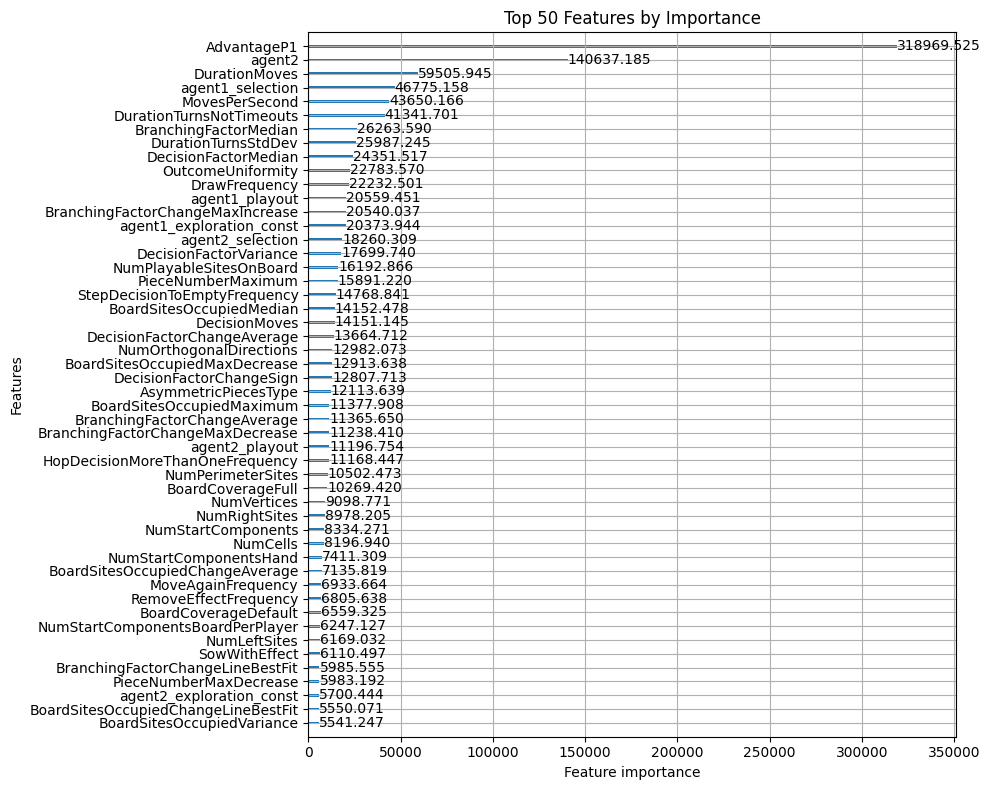

Fold 4 - RMSE: 0.43927395033639394
Fold 5


[100]	valid_0's rmse: 0.524266


[200]	valid_0's rmse: 0.497186


[300]	valid_0's rmse: 0.482969


[400]	valid_0's rmse: 0.472353


[500]	valid_0's rmse: 0.466213


[600]	valid_0's rmse: 0.462438


[700]	valid_0's rmse: 0.459678


[800]	valid_0's rmse: 0.457896


[900]	valid_0's rmse: 0.456098


[1000]	valid_0's rmse: 0.454236


[1100]	valid_0's rmse: 0.452698


[1200]	valid_0's rmse: 0.451531


[1300]	valid_0's rmse: 0.450133


[1400]	valid_0's rmse: 0.448902


[1500]	valid_0's rmse: 0.447706


[1600]	valid_0's rmse: 0.446741


[1700]	valid_0's rmse: 0.446019


[1800]	valid_0's rmse: 0.445159


[1900]	valid_0's rmse: 0.444419


[2000]	valid_0's rmse: 0.443754


[2100]	valid_0's rmse: 0.442977


[2200]	valid_0's rmse: 0.442527


[2300]	valid_0's rmse: 0.442042


[2400]	valid_0's rmse: 0.441569


[2500]	valid_0's rmse: 0.441173


[2600]	valid_0's rmse: 0.440742


[2700]	valid_0's rmse: 0.440343


[2800]	valid_0's rmse: 0.439875


[2900]	valid_0's rmse: 0.439518


[3000]	valid_0's rmse: 0.439042


[3100]	valid_0's rmse: 0.438768


[3200]	valid_0's rmse: 0.438534


[3300]	valid_0's rmse: 0.438144


[3400]	valid_0's rmse: 0.437866


[3500]	valid_0's rmse: 0.437568


[3600]	valid_0's rmse: 0.437298


[3700]	valid_0's rmse: 0.437068


[3800]	valid_0's rmse: 0.436921


[3900]	valid_0's rmse: 0.436729


[4000]	valid_0's rmse: 0.436453


[4100]	valid_0's rmse: 0.436259


[4200]	valid_0's rmse: 0.436072


[4300]	valid_0's rmse: 0.435861


[4400]	valid_0's rmse: 0.435599


[4500]	valid_0's rmse: 0.435412


[4600]	valid_0's rmse: 0.43526


[4700]	valid_0's rmse: 0.435111


[4800]	valid_0's rmse: 0.434946


[4900]	valid_0's rmse: 0.434798


[5000]	valid_0's rmse: 0.434595


[5100]	valid_0's rmse: 0.434476


[5200]	valid_0's rmse: 0.434324


[5300]	valid_0's rmse: 0.434183


[5400]	valid_0's rmse: 0.434057


[5500]	valid_0's rmse: 0.433763


[5600]	valid_0's rmse: 0.433586


[5700]	valid_0's rmse: 0.433392


[5800]	valid_0's rmse: 0.433293


[5900]	valid_0's rmse: 0.433192


[6000]	valid_0's rmse: 0.433067


[6100]	valid_0's rmse: 0.433095


[6200]	valid_0's rmse: 0.433022


[6300]	valid_0's rmse: 0.432962


[6400]	valid_0's rmse: 0.432916


[6500]	valid_0's rmse: 0.43285


[6600]	valid_0's rmse: 0.43276


[6700]	valid_0's rmse: 0.432685


[6800]	valid_0's rmse: 0.432478


[6900]	valid_0's rmse: 0.432488


[7000]	valid_0's rmse: 0.432465


[7100]	valid_0's rmse: 0.432368


[7200]	valid_0's rmse: 0.432242


[7300]	valid_0's rmse: 0.432202


[7400]	valid_0's rmse: 0.432164


[7500]	valid_0's rmse: 0.432111


[7600]	valid_0's rmse: 0.432061


[7700]	valid_0's rmse: 0.432053


[7800]	valid_0's rmse: 0.432014


[7900]	valid_0's rmse: 0.431937


[8000]	valid_0's rmse: 0.431866


[8100]	valid_0's rmse: 0.431836


[8200]	valid_0's rmse: 0.431832


[8300]	valid_0's rmse: 0.431813


[8400]	valid_0's rmse: 0.431771


[8500]	valid_0's rmse: 0.431707


[8600]	valid_0's rmse: 0.4316


[8700]	valid_0's rmse: 0.431616


[8800]	valid_0's rmse: 0.431566


[8900]	valid_0's rmse: 0.431562


[9000]	valid_0's rmse: 0.431511


[9100]	valid_0's rmse: 0.431462


[9200]	valid_0's rmse: 0.431443


[9300]	valid_0's rmse: 0.431433


[9400]	valid_0's rmse: 0.431441


[9500]	valid_0's rmse: 0.431438


[9600]	valid_0's rmse: 0.431385


[9700]	valid_0's rmse: 0.431327


[9800]	valid_0's rmse: 0.431286


[9900]	valid_0's rmse: 0.431279


[10000]	valid_0's rmse: 0.431322


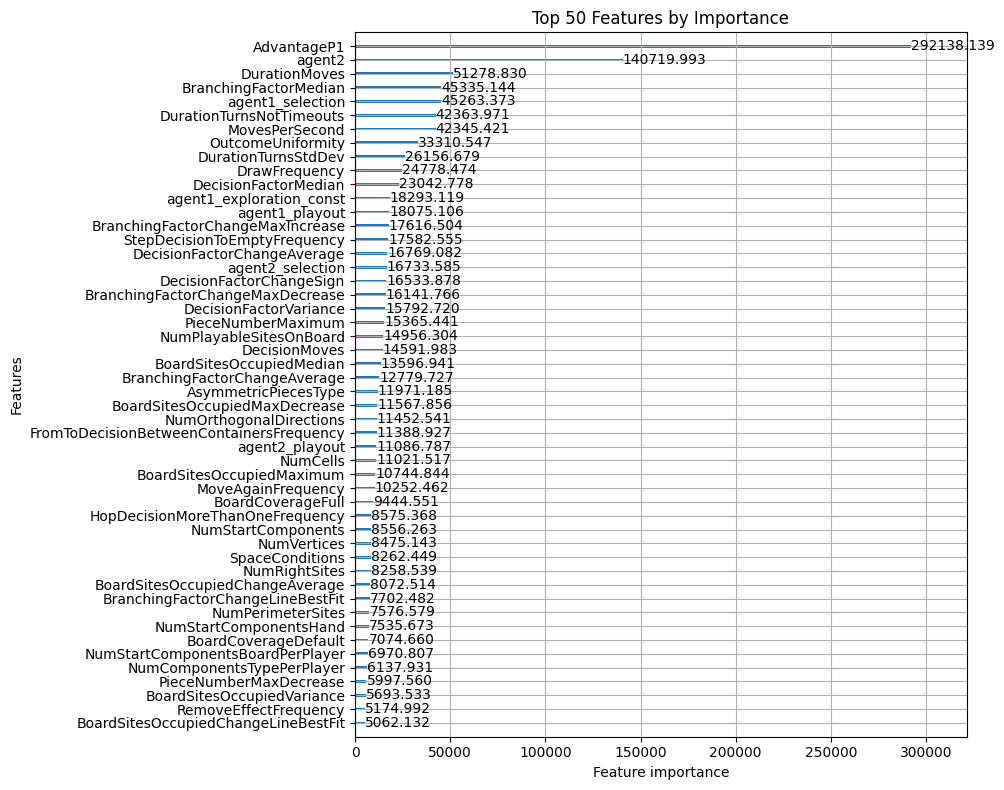

Fold 5 - RMSE: 0.43073588423066783
List of oof scores: [0.41621179450543005, 0.4014732283394731, 0.4345446390648151, 0.43927395033639394, 0.43073588423066783]
Average oof score: 0.4244478992953559


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.508331


[200]	valid_0's rmse: 0.48262


[300]	valid_0's rmse: 0.467187


[400]	valid_0's rmse: 0.457448


[500]	valid_0's rmse: 0.451849


[600]	valid_0's rmse: 0.44856


[700]	valid_0's rmse: 0.446125


[800]	valid_0's rmse: 0.44435


[900]	valid_0's rmse: 0.442729


[1000]	valid_0's rmse: 0.441341


[1100]	valid_0's rmse: 0.440246


[1200]	valid_0's rmse: 0.439075


[1300]	valid_0's rmse: 0.438062


[1400]	valid_0's rmse: 0.437296


[1500]	valid_0's rmse: 0.436479


[1600]	valid_0's rmse: 0.435695


[1700]	valid_0's rmse: 0.434968


[1800]	valid_0's rmse: 0.434207


[1900]	valid_0's rmse: 0.43386


[2000]	valid_0's rmse: 0.43342


[2100]	valid_0's rmse: 0.432933


[2200]	valid_0's rmse: 0.432587


[2300]	valid_0's rmse: 0.432273


[2400]	valid_0's rmse: 0.431902


[2500]	valid_0's rmse: 0.431561


[2600]	valid_0's rmse: 0.431312


[2700]	valid_0's rmse: 0.431095


[2800]	valid_0's rmse: 0.4309


[2900]	valid_0's rmse: 0.430664


[3000]	valid_0's rmse: 0.43044


[3100]	valid_0's rmse: 0.430133


[3200]	valid_0's rmse: 0.429929


[3300]	valid_0's rmse: 0.429695


[3400]	valid_0's rmse: 0.429466


[3500]	valid_0's rmse: 0.429256


[3600]	valid_0's rmse: 0.429066


[3700]	valid_0's rmse: 0.428972


[3800]	valid_0's rmse: 0.428675


[3900]	valid_0's rmse: 0.428529


[4000]	valid_0's rmse: 0.428287


[4100]	valid_0's rmse: 0.428052


[4200]	valid_0's rmse: 0.427845


[4300]	valid_0's rmse: 0.427674


[4400]	valid_0's rmse: 0.4275


[4500]	valid_0's rmse: 0.427364


[4600]	valid_0's rmse: 0.427203


[4700]	valid_0's rmse: 0.427043


[4800]	valid_0's rmse: 0.426936


[4900]	valid_0's rmse: 0.426979


[5000]	valid_0's rmse: 0.426838


[5100]	valid_0's rmse: 0.426664


[5200]	valid_0's rmse: 0.426547


[5300]	valid_0's rmse: 0.426445


[5400]	valid_0's rmse: 0.426401


[5500]	valid_0's rmse: 0.426253


[5600]	valid_0's rmse: 0.426189


[5700]	valid_0's rmse: 0.426107


[5800]	valid_0's rmse: 0.425983


[5900]	valid_0's rmse: 0.425892


[6000]	valid_0's rmse: 0.425857


[6100]	valid_0's rmse: 0.425836


[6200]	valid_0's rmse: 0.42578


[6300]	valid_0's rmse: 0.425607


[6400]	valid_0's rmse: 0.425585


[6500]	valid_0's rmse: 0.425417


[6600]	valid_0's rmse: 0.42538


[6700]	valid_0's rmse: 0.425344


[6800]	valid_0's rmse: 0.425269


[6900]	valid_0's rmse: 0.425253


[7000]	valid_0's rmse: 0.4253


[7100]	valid_0's rmse: 0.42526


[7200]	valid_0's rmse: 0.425237


[7300]	valid_0's rmse: 0.42522


[7400]	valid_0's rmse: 0.425196


[7500]	valid_0's rmse: 0.425181


[7600]	valid_0's rmse: 0.425146


[7700]	valid_0's rmse: 0.425112


[7800]	valid_0's rmse: 0.425093


[7900]	valid_0's rmse: 0.425057


[8000]	valid_0's rmse: 0.425033


[8100]	valid_0's rmse: 0.425064


[8200]	valid_0's rmse: 0.425037


[8300]	valid_0's rmse: 0.42501


[8400]	valid_0's rmse: 0.425031


[8500]	valid_0's rmse: 0.425053


[8600]	valid_0's rmse: 0.425035


[8700]	valid_0's rmse: 0.425018


[8800]	valid_0's rmse: 0.424992


[8900]	valid_0's rmse: 0.424968


[9000]	valid_0's rmse: 0.42497


[9100]	valid_0's rmse: 0.424944


[9200]	valid_0's rmse: 0.424871


[9300]	valid_0's rmse: 0.424832


[9400]	valid_0's rmse: 0.424813


[9500]	valid_0's rmse: 0.424776


[9600]	valid_0's rmse: 0.424716


[9700]	valid_0's rmse: 0.424675


[9800]	valid_0's rmse: 0.424676


[9900]	valid_0's rmse: 0.424618


[10000]	valid_0's rmse: 0.424609


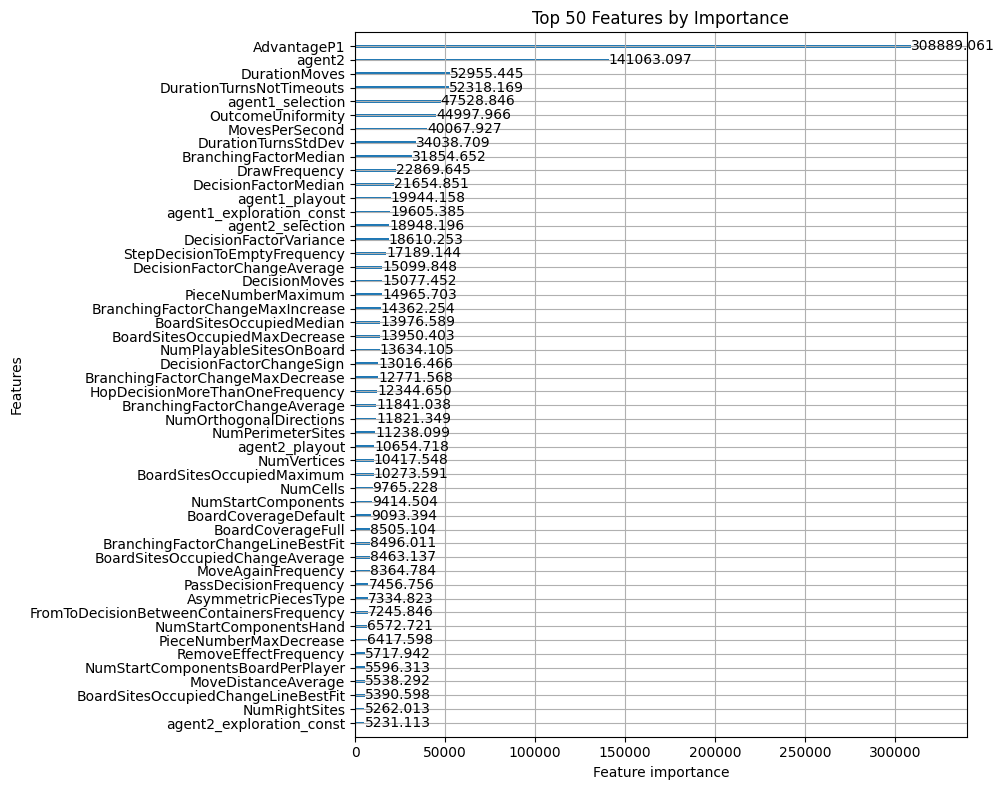

Fold 1 - RMSE: 0.4241038017752421
Fold 2


[100]	valid_0's rmse: 0.511118


[200]	valid_0's rmse: 0.487141


[300]	valid_0's rmse: 0.473725


[400]	valid_0's rmse: 0.463947


[500]	valid_0's rmse: 0.458409


[600]	valid_0's rmse: 0.454007


[700]	valid_0's rmse: 0.451023


[800]	valid_0's rmse: 0.448349


[900]	valid_0's rmse: 0.445961


[1000]	valid_0's rmse: 0.444249


[1100]	valid_0's rmse: 0.442738


[1200]	valid_0's rmse: 0.441095


[1300]	valid_0's rmse: 0.439837


[1400]	valid_0's rmse: 0.43842


[1500]	valid_0's rmse: 0.437474


[1600]	valid_0's rmse: 0.436405


[1700]	valid_0's rmse: 0.43544


[1800]	valid_0's rmse: 0.434372


[1900]	valid_0's rmse: 0.433566


[2000]	valid_0's rmse: 0.432796


[2100]	valid_0's rmse: 0.431931


[2200]	valid_0's rmse: 0.43127


[2300]	valid_0's rmse: 0.430657


[2400]	valid_0's rmse: 0.430121


[2500]	valid_0's rmse: 0.429434


[2600]	valid_0's rmse: 0.42904


[2700]	valid_0's rmse: 0.428495


[2800]	valid_0's rmse: 0.427966


[2900]	valid_0's rmse: 0.427542


[3000]	valid_0's rmse: 0.426999


[3100]	valid_0's rmse: 0.426633


[3200]	valid_0's rmse: 0.42623


[3300]	valid_0's rmse: 0.425812


[3400]	valid_0's rmse: 0.425453


[3500]	valid_0's rmse: 0.425131


[3600]	valid_0's rmse: 0.4247


[3700]	valid_0's rmse: 0.424398


[3800]	valid_0's rmse: 0.424147


[3900]	valid_0's rmse: 0.423882


[4000]	valid_0's rmse: 0.423486


[4100]	valid_0's rmse: 0.423238


[4200]	valid_0's rmse: 0.422996


[4300]	valid_0's rmse: 0.422739


[4400]	valid_0's rmse: 0.422488


[4500]	valid_0's rmse: 0.422234


[4600]	valid_0's rmse: 0.422053


[4700]	valid_0's rmse: 0.421815


[4800]	valid_0's rmse: 0.42147


[4900]	valid_0's rmse: 0.421191


[5000]	valid_0's rmse: 0.421103


[5100]	valid_0's rmse: 0.420972


[5200]	valid_0's rmse: 0.420749


[5300]	valid_0's rmse: 0.420607


[5400]	valid_0's rmse: 0.420456


[5500]	valid_0's rmse: 0.420281


[5600]	valid_0's rmse: 0.420202


[5700]	valid_0's rmse: 0.420035


[5800]	valid_0's rmse: 0.419848


[5900]	valid_0's rmse: 0.419622


[6000]	valid_0's rmse: 0.419497


[6100]	valid_0's rmse: 0.419336


[6200]	valid_0's rmse: 0.419233


[6300]	valid_0's rmse: 0.419089


[6400]	valid_0's rmse: 0.41901


[6500]	valid_0's rmse: 0.418861


[6600]	valid_0's rmse: 0.418746


[6700]	valid_0's rmse: 0.418605


[6800]	valid_0's rmse: 0.418494


[6900]	valid_0's rmse: 0.418369


[7000]	valid_0's rmse: 0.418164


[7100]	valid_0's rmse: 0.418071


[7200]	valid_0's rmse: 0.41796


[7300]	valid_0's rmse: 0.417885


[7400]	valid_0's rmse: 0.417894


[7500]	valid_0's rmse: 0.417816


[7600]	valid_0's rmse: 0.417683


[7700]	valid_0's rmse: 0.417586


[7800]	valid_0's rmse: 0.417524


[7900]	valid_0's rmse: 0.417422


[8000]	valid_0's rmse: 0.417391


[8100]	valid_0's rmse: 0.41733


[8200]	valid_0's rmse: 0.417295


[8300]	valid_0's rmse: 0.417277


[8400]	valid_0's rmse: 0.417231


[8500]	valid_0's rmse: 0.41711


[8600]	valid_0's rmse: 0.417058


[8700]	valid_0's rmse: 0.416986


[8800]	valid_0's rmse: 0.416895


[8900]	valid_0's rmse: 0.416839


[9000]	valid_0's rmse: 0.416781


[9100]	valid_0's rmse: 0.41665


[9200]	valid_0's rmse: 0.416635


[9300]	valid_0's rmse: 0.416626


[9400]	valid_0's rmse: 0.416532


[9500]	valid_0's rmse: 0.416496


[9600]	valid_0's rmse: 0.416432


[9700]	valid_0's rmse: 0.416354


[9800]	valid_0's rmse: 0.416282


[9900]	valid_0's rmse: 0.416243


[10000]	valid_0's rmse: 0.416154


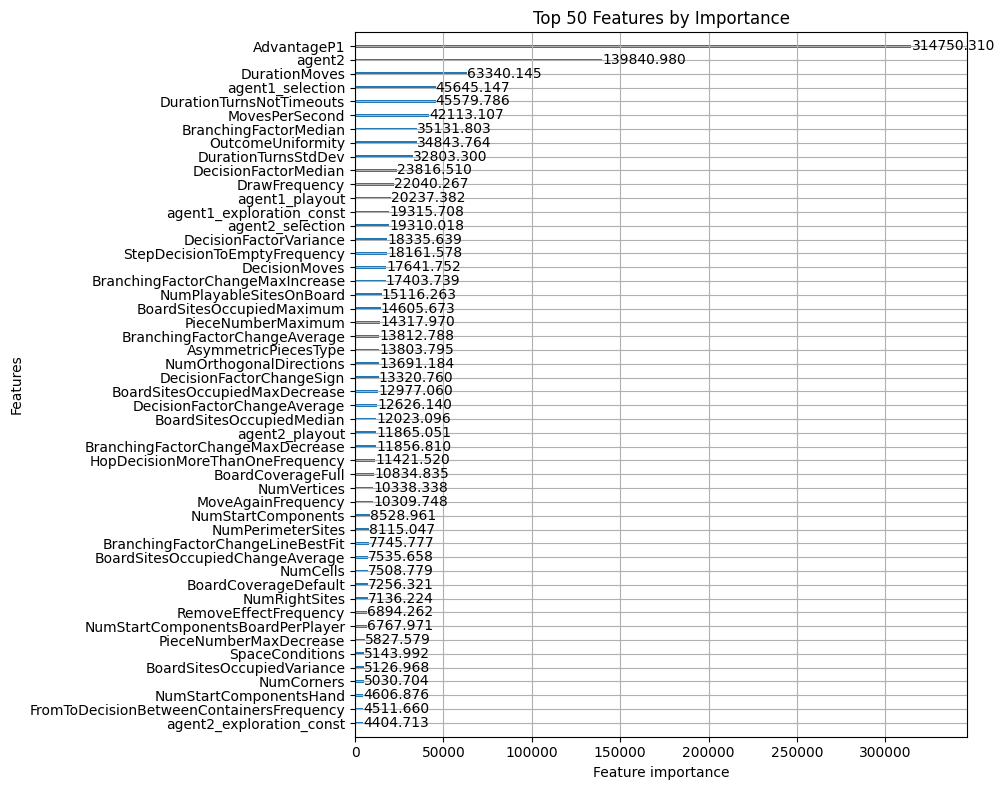

Fold 2 - RMSE: 0.4157434622859
Fold 3


[100]	valid_0's rmse: 0.504336


[200]	valid_0's rmse: 0.47983


[300]	valid_0's rmse: 0.468143


[400]	valid_0's rmse: 0.459283


[500]	valid_0's rmse: 0.453621


[600]	valid_0's rmse: 0.450565


[700]	valid_0's rmse: 0.448651


[800]	valid_0's rmse: 0.446866


[900]	valid_0's rmse: 0.445075


[1000]	valid_0's rmse: 0.443558


[1100]	valid_0's rmse: 0.442501


[1200]	valid_0's rmse: 0.441212


[1300]	valid_0's rmse: 0.440323


[1400]	valid_0's rmse: 0.439296


[1500]	valid_0's rmse: 0.43825


[1600]	valid_0's rmse: 0.437391


[1700]	valid_0's rmse: 0.436775


[1800]	valid_0's rmse: 0.436205


[1900]	valid_0's rmse: 0.435653


[2000]	valid_0's rmse: 0.435144


[2100]	valid_0's rmse: 0.434842


[2200]	valid_0's rmse: 0.434381


[2300]	valid_0's rmse: 0.43392


[2400]	valid_0's rmse: 0.433429


[2500]	valid_0's rmse: 0.432912


[2600]	valid_0's rmse: 0.432672


[2700]	valid_0's rmse: 0.432408


[2800]	valid_0's rmse: 0.432268


[2900]	valid_0's rmse: 0.432015


[3000]	valid_0's rmse: 0.431679


[3100]	valid_0's rmse: 0.431435


[3200]	valid_0's rmse: 0.431269


[3300]	valid_0's rmse: 0.430911


[3400]	valid_0's rmse: 0.430648


[3500]	valid_0's rmse: 0.430368


[3600]	valid_0's rmse: 0.430001


[3700]	valid_0's rmse: 0.429866


[3800]	valid_0's rmse: 0.429588


[3900]	valid_0's rmse: 0.429251


[4000]	valid_0's rmse: 0.429129


[4100]	valid_0's rmse: 0.428932


[4200]	valid_0's rmse: 0.428779


[4300]	valid_0's rmse: 0.428607


[4400]	valid_0's rmse: 0.428348


[4500]	valid_0's rmse: 0.428174


[4600]	valid_0's rmse: 0.428054


[4700]	valid_0's rmse: 0.427796


[4800]	valid_0's rmse: 0.427567


[4900]	valid_0's rmse: 0.427329


[5000]	valid_0's rmse: 0.427241


[5100]	valid_0's rmse: 0.427071


[5200]	valid_0's rmse: 0.427015


[5300]	valid_0's rmse: 0.426902


[5400]	valid_0's rmse: 0.426837


[5500]	valid_0's rmse: 0.426717


[5600]	valid_0's rmse: 0.426633


[5700]	valid_0's rmse: 0.42655


[5800]	valid_0's rmse: 0.42654


[5900]	valid_0's rmse: 0.426444


[6000]	valid_0's rmse: 0.426328


[6100]	valid_0's rmse: 0.426243


[6200]	valid_0's rmse: 0.426186


[6300]	valid_0's rmse: 0.426072


[6400]	valid_0's rmse: 0.426044


[6500]	valid_0's rmse: 0.425887


[6600]	valid_0's rmse: 0.425863


[6700]	valid_0's rmse: 0.425813


[6800]	valid_0's rmse: 0.42573


[6900]	valid_0's rmse: 0.425727


[7000]	valid_0's rmse: 0.425655


[7100]	valid_0's rmse: 0.425646


[7200]	valid_0's rmse: 0.425565


[7300]	valid_0's rmse: 0.425521


[7400]	valid_0's rmse: 0.425489


[7500]	valid_0's rmse: 0.425468


[7600]	valid_0's rmse: 0.425479


[7700]	valid_0's rmse: 0.425409


[7800]	valid_0's rmse: 0.425307


[7900]	valid_0's rmse: 0.42527


[8000]	valid_0's rmse: 0.425219


[8100]	valid_0's rmse: 0.425195


[8200]	valid_0's rmse: 0.425161


[8300]	valid_0's rmse: 0.425128


[8400]	valid_0's rmse: 0.425114


[8500]	valid_0's rmse: 0.425121


[8600]	valid_0's rmse: 0.425109


[8700]	valid_0's rmse: 0.42504


[8800]	valid_0's rmse: 0.424962


[8900]	valid_0's rmse: 0.424964


[9000]	valid_0's rmse: 0.42497


[9100]	valid_0's rmse: 0.424991


[9200]	valid_0's rmse: 0.42499


[9300]	valid_0's rmse: 0.424971


[9400]	valid_0's rmse: 0.425031


[9500]	valid_0's rmse: 0.425003


[9600]	valid_0's rmse: 0.424934


[9700]	valid_0's rmse: 0.424841


[9800]	valid_0's rmse: 0.424802


[9900]	valid_0's rmse: 0.424809


[10000]	valid_0's rmse: 0.424744


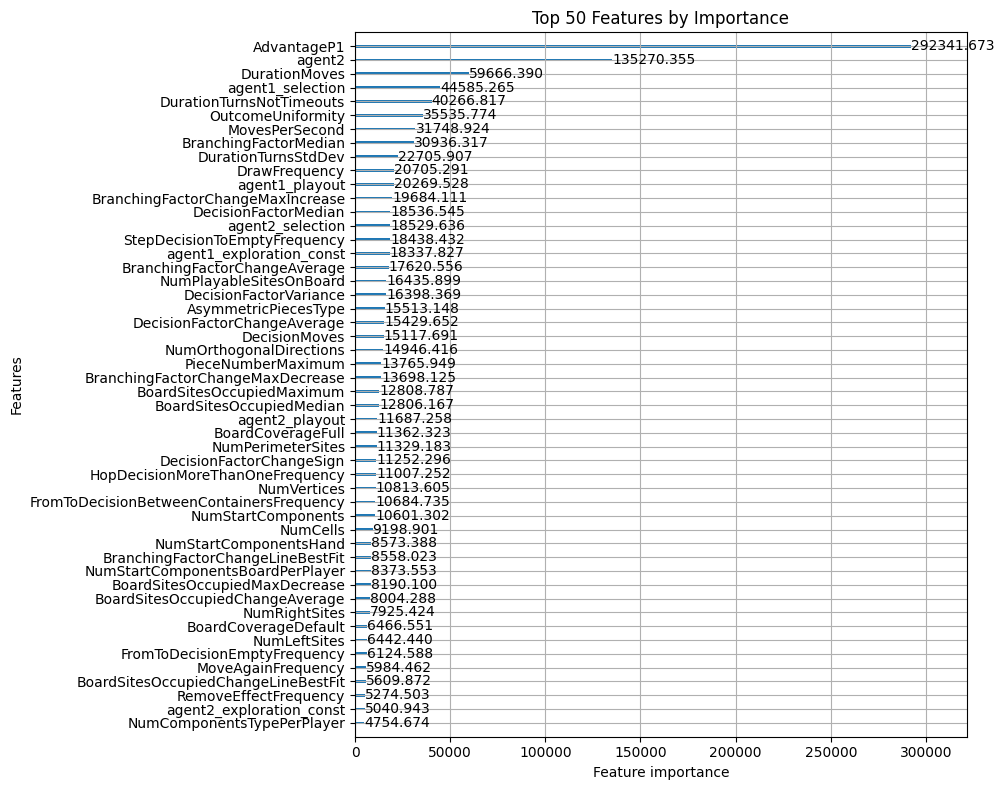

Fold 3 - RMSE: 0.424329531803597
Fold 4


[100]	valid_0's rmse: 0.492686


[200]	valid_0's rmse: 0.469037


[300]	valid_0's rmse: 0.456417


[400]	valid_0's rmse: 0.448779


[500]	valid_0's rmse: 0.443853


[600]	valid_0's rmse: 0.440789


[700]	valid_0's rmse: 0.438767


[800]	valid_0's rmse: 0.437401


[900]	valid_0's rmse: 0.435866


[1000]	valid_0's rmse: 0.434843


[1100]	valid_0's rmse: 0.433604


[1200]	valid_0's rmse: 0.432558


[1300]	valid_0's rmse: 0.431416


[1400]	valid_0's rmse: 0.430605


[1500]	valid_0's rmse: 0.429785


[1600]	valid_0's rmse: 0.42901


[1700]	valid_0's rmse: 0.428179


[1800]	valid_0's rmse: 0.427818


[1900]	valid_0's rmse: 0.427182


[2000]	valid_0's rmse: 0.426861


[2100]	valid_0's rmse: 0.42644


[2200]	valid_0's rmse: 0.426126


[2300]	valid_0's rmse: 0.425758


[2400]	valid_0's rmse: 0.425253


[2500]	valid_0's rmse: 0.424921


[2600]	valid_0's rmse: 0.424674


[2700]	valid_0's rmse: 0.424366


[2800]	valid_0's rmse: 0.424049


[2900]	valid_0's rmse: 0.423833


[3000]	valid_0's rmse: 0.42352


[3100]	valid_0's rmse: 0.423278


[3200]	valid_0's rmse: 0.423105


[3300]	valid_0's rmse: 0.42288


[3400]	valid_0's rmse: 0.422681


[3500]	valid_0's rmse: 0.422578


[3600]	valid_0's rmse: 0.422335


[3700]	valid_0's rmse: 0.422091


[3800]	valid_0's rmse: 0.421907


[3900]	valid_0's rmse: 0.421801


[4000]	valid_0's rmse: 0.421613


[4100]	valid_0's rmse: 0.421553


[4200]	valid_0's rmse: 0.421312


[4300]	valid_0's rmse: 0.42114


[4400]	valid_0's rmse: 0.421007


[4500]	valid_0's rmse: 0.42076


[4600]	valid_0's rmse: 0.420562


[4700]	valid_0's rmse: 0.420551


[4800]	valid_0's rmse: 0.420406


[4900]	valid_0's rmse: 0.420298


[5000]	valid_0's rmse: 0.420213


[5100]	valid_0's rmse: 0.420156


[5200]	valid_0's rmse: 0.419961


[5300]	valid_0's rmse: 0.419885


[5400]	valid_0's rmse: 0.419755


[5500]	valid_0's rmse: 0.419618


[5600]	valid_0's rmse: 0.419496


[5700]	valid_0's rmse: 0.419474


[5800]	valid_0's rmse: 0.419397


[5900]	valid_0's rmse: 0.419324


[6000]	valid_0's rmse: 0.419179


[6100]	valid_0's rmse: 0.419178


[6200]	valid_0's rmse: 0.419174


[6300]	valid_0's rmse: 0.419068


[6400]	valid_0's rmse: 0.418987


[6500]	valid_0's rmse: 0.418933


[6600]	valid_0's rmse: 0.4189


[6700]	valid_0's rmse: 0.418889


[6800]	valid_0's rmse: 0.418753


[6900]	valid_0's rmse: 0.418676


[7000]	valid_0's rmse: 0.418604


[7100]	valid_0's rmse: 0.41856


[7200]	valid_0's rmse: 0.418502


[7300]	valid_0's rmse: 0.418465


[7400]	valid_0's rmse: 0.418407


[7500]	valid_0's rmse: 0.418452


[7600]	valid_0's rmse: 0.418391


[7700]	valid_0's rmse: 0.418397


[7800]	valid_0's rmse: 0.418359


[7900]	valid_0's rmse: 0.418289


[8000]	valid_0's rmse: 0.418175


[8100]	valid_0's rmse: 0.41813


[8200]	valid_0's rmse: 0.418124


[8300]	valid_0's rmse: 0.418117


[8400]	valid_0's rmse: 0.418146


[8500]	valid_0's rmse: 0.418116


[8600]	valid_0's rmse: 0.418106


[8700]	valid_0's rmse: 0.418098


[8800]	valid_0's rmse: 0.418064


[8900]	valid_0's rmse: 0.418052


[9000]	valid_0's rmse: 0.418021


[9100]	valid_0's rmse: 0.418045


[9200]	valid_0's rmse: 0.418058


[9300]	valid_0's rmse: 0.418095


[9400]	valid_0's rmse: 0.418093


[9500]	valid_0's rmse: 0.418054


[9600]	valid_0's rmse: 0.418034


[9700]	valid_0's rmse: 0.418044


[9800]	valid_0's rmse: 0.418018


[9900]	valid_0's rmse: 0.418009


[10000]	valid_0's rmse: 0.418031


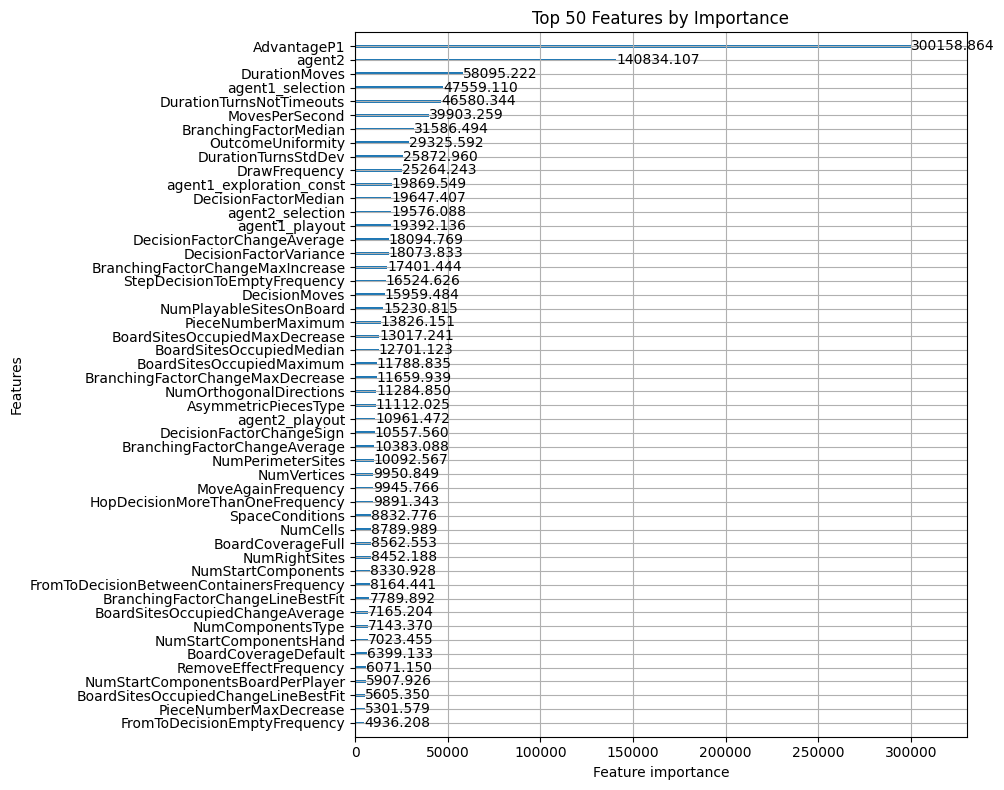

Fold 4 - RMSE: 0.41752141571692963
Fold 5


[100]	valid_0's rmse: 0.517721


[200]	valid_0's rmse: 0.489893


[300]	valid_0's rmse: 0.47425


[400]	valid_0's rmse: 0.463827


[500]	valid_0's rmse: 0.457933


[600]	valid_0's rmse: 0.453561


[700]	valid_0's rmse: 0.450665


[800]	valid_0's rmse: 0.447887


[900]	valid_0's rmse: 0.44553


[1000]	valid_0's rmse: 0.443572


[1100]	valid_0's rmse: 0.442049


[1200]	valid_0's rmse: 0.440601


[1300]	valid_0's rmse: 0.439227


[1400]	valid_0's rmse: 0.438177


[1500]	valid_0's rmse: 0.437213


[1600]	valid_0's rmse: 0.436267


[1700]	valid_0's rmse: 0.435351


[1800]	valid_0's rmse: 0.434407


[1900]	valid_0's rmse: 0.433804


[2000]	valid_0's rmse: 0.433093


[2100]	valid_0's rmse: 0.432498


[2200]	valid_0's rmse: 0.431891


[2300]	valid_0's rmse: 0.431191


[2400]	valid_0's rmse: 0.430591


[2500]	valid_0's rmse: 0.429989


[2600]	valid_0's rmse: 0.429434


[2700]	valid_0's rmse: 0.428947


[2800]	valid_0's rmse: 0.428702


[2900]	valid_0's rmse: 0.428277


[3000]	valid_0's rmse: 0.427822


[3100]	valid_0's rmse: 0.427355


[3200]	valid_0's rmse: 0.42694


[3300]	valid_0's rmse: 0.426641


[3400]	valid_0's rmse: 0.426244


[3500]	valid_0's rmse: 0.42587


[3600]	valid_0's rmse: 0.425606


[3700]	valid_0's rmse: 0.42532


[3800]	valid_0's rmse: 0.425095


[3900]	valid_0's rmse: 0.42479


[4000]	valid_0's rmse: 0.42452


[4100]	valid_0's rmse: 0.424186


[4200]	valid_0's rmse: 0.423957


[4300]	valid_0's rmse: 0.423675


[4400]	valid_0's rmse: 0.423425


[4500]	valid_0's rmse: 0.423158


[4600]	valid_0's rmse: 0.42308


[4700]	valid_0's rmse: 0.422939


[4800]	valid_0's rmse: 0.422734


[4900]	valid_0's rmse: 0.422506


[5000]	valid_0's rmse: 0.422362


[5100]	valid_0's rmse: 0.422234


[5200]	valid_0's rmse: 0.422104


[5300]	valid_0's rmse: 0.421953


[5400]	valid_0's rmse: 0.421836


[5500]	valid_0's rmse: 0.421686


[5600]	valid_0's rmse: 0.421586


[5700]	valid_0's rmse: 0.421374


[5800]	valid_0's rmse: 0.421234


[5900]	valid_0's rmse: 0.421194


[6000]	valid_0's rmse: 0.42105


[6100]	valid_0's rmse: 0.420897


[6200]	valid_0's rmse: 0.420765


[6300]	valid_0's rmse: 0.420647


[6400]	valid_0's rmse: 0.420493


[6500]	valid_0's rmse: 0.42044


[6600]	valid_0's rmse: 0.42034


[6700]	valid_0's rmse: 0.420183


[6800]	valid_0's rmse: 0.420082


[6900]	valid_0's rmse: 0.419925


[7000]	valid_0's rmse: 0.419832


[7100]	valid_0's rmse: 0.419771


[7200]	valid_0's rmse: 0.419741


[7300]	valid_0's rmse: 0.419605


[7400]	valid_0's rmse: 0.419531


[7500]	valid_0's rmse: 0.419436


[7600]	valid_0's rmse: 0.419415


[7700]	valid_0's rmse: 0.419248


[7800]	valid_0's rmse: 0.419179


[7900]	valid_0's rmse: 0.419102


[8000]	valid_0's rmse: 0.419007


[8100]	valid_0's rmse: 0.418939


[8200]	valid_0's rmse: 0.41888


[8300]	valid_0's rmse: 0.418804


[8400]	valid_0's rmse: 0.418742


[8500]	valid_0's rmse: 0.418703


[8600]	valid_0's rmse: 0.418578


[8700]	valid_0's rmse: 0.41849


[8800]	valid_0's rmse: 0.418419


[8900]	valid_0's rmse: 0.418388


[9000]	valid_0's rmse: 0.41838


[9100]	valid_0's rmse: 0.418288


[9200]	valid_0's rmse: 0.418239


[9300]	valid_0's rmse: 0.418193


[9400]	valid_0's rmse: 0.418147


[9500]	valid_0's rmse: 0.418077


[9600]	valid_0's rmse: 0.418123


[9700]	valid_0's rmse: 0.418097


[9800]	valid_0's rmse: 0.418048


[9900]	valid_0's rmse: 0.418003


[10000]	valid_0's rmse: 0.417961


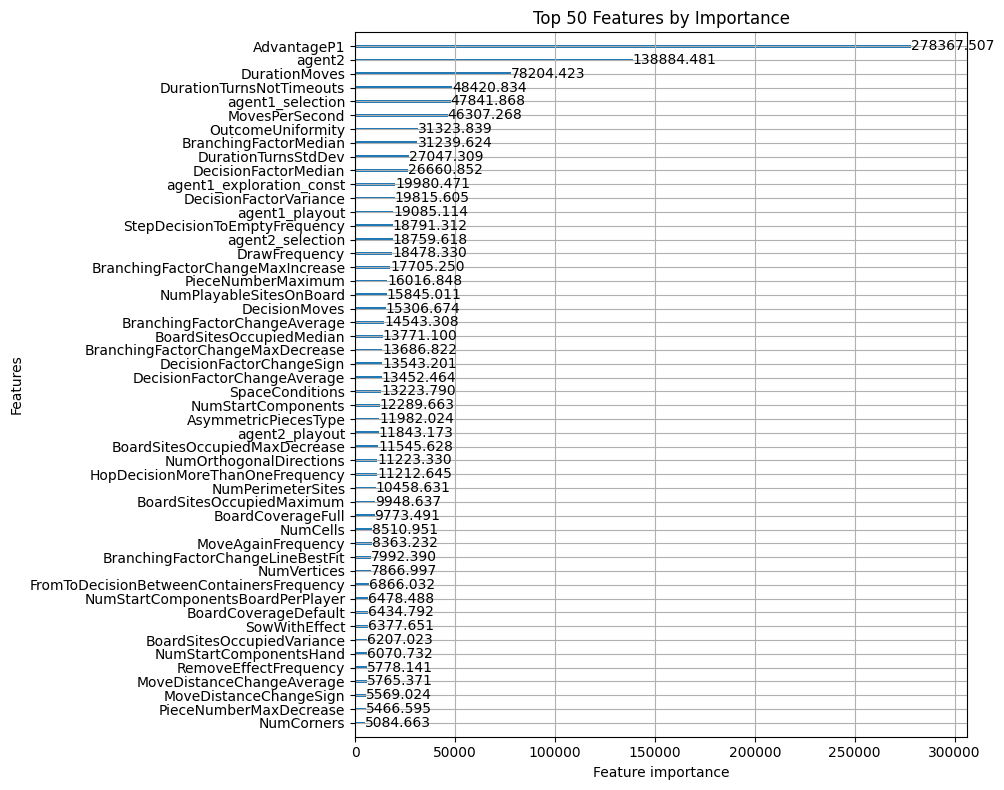

Fold 5 - RMSE: 0.4173839965149246
List of oof scores: [0.4241038017752421, 0.4157434622859, 0.424329531803597, 0.41752141571692963, 0.4173839965149246]
Average oof score: 0.4198164416193186


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4282
Score: 0.4401
Score: 0.4345
Score: 0.4300
Score: 0.4028
Average CV1 Score: 0.4271

CV2 OOF Scores:
Score: 0.4162
Score: 0.4015
Score: 0.4345
Score: 0.4393
Score: 0.4307
Average CV2 Score: 0.4244

CV3 OOF Scores:
Score: 0.4241
Score: 0.4157
Score: 0.4243
Score: 0.4175
Score: 0.4174
Average CV3 Score: 0.4198


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

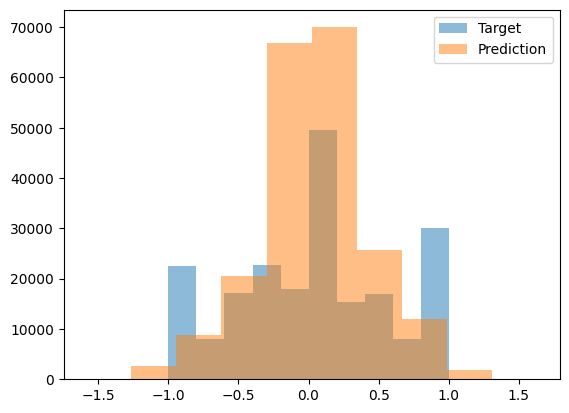

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.107667       │
│ 233235 ┆ -0.207906      │
│ 233236 ┆ -0.039521      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***